<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/ST_prediction_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

NN for predicting ST from theoretical data based on the somple model

In [1]:
!pip install lmfit
# !pip install git+https://github.com/ulikoehler/UliEngineering.git


In [2]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  #!!! Why though? !!!

import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import io
from scipy.interpolate import interp1d

# from UliEngineering.Math.Coordinates import BoundingBox

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.
    Parameters
    ----------
    x, y - cartesian coordinates of contour of the drop [mm]
    Returns
    -------
    Integrated volume using for the given shape matrix.
    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth_old(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    a=np.arctan2(x, y)
    return a


def azimuth(x, y):
    """
    Calculate the azimuthal angle.
    Input parameters
    ----------
    x, y: Cartesian coordinates of contour of the drop [mm]
    Returns
    -------
    Azimuthal angle in [rad]
    """
    a=np.arctan2(x, y)
    return a

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

Instructions for updating:
non-resource variables are not supported in the long term
2.8.0
Num GPUs Available:  0


Run the next code box only if google drive is not mounted to colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [ ]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
import numpy as np
file1=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_20.00_Ps_2882.0.csv'), sep="\t")
file2=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_22.00_Ps_2882.0.csv'), sep="\t")
file3=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_25.00_Ps_2882.0.csv'), sep="\t")
file4=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_27.00_Ps_2882.0.csv'), sep="\t")
file5=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_30.00_Ps_2882.0.csv'), sep="\t")
file6=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_32.00_Ps_2882.0.csv'), sep="\t")
file7=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_35.00_Ps_2882.0.csv'), sep="\t")
file8=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_40.00_Ps_2882.0.csv'), sep="\t")
file9=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_45.00_Ps_2882.0.csv'), sep="\t")
file10=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_50.00_Ps_2882.0.csv'), sep="\t")
file11=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_55.00_Ps_2882.0.csv'), sep="\t")
file12=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_60.00_Ps_2882.0.csv'), sep="\t")
file13=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_65.00_Ps_2882.0.csv'), sep="\t")
file14=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_70.00_Ps_2882.0.csv'), sep="\t")
file15=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_72.00_Ps_2882.0.csv'), sep="\t")
file16=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_20.00_Rsph_0.54.csv'), sep="\t")
file17=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_22.00_Rsph_0.67.csv'), sep="\t")
file18=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.59.csv'), sep="\t")
file19=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.67.csv'), sep="\t")
file20=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_30.00_Rsph_0.67.csv'), sep="\t")
file21=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_35.00_Rsph_0.67.csv'), sep="\t")
file22=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_40.00_Rsph_0.80.csv'), sep="\t")
file23=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_45.00_Rsph_0.94.csv'), sep="\t")
file24=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_50.00_Rsph_1.07.csv'), sep="\t")
file25=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_55.00_Rsph_1.21.csv'), sep="\t")
file26=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_60.00_Rsph_1.34.csv'), sep="\t")
file27=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.45.csv'), sep="\t")
file28=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.47.csv'), sep="\t")
file29=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_70.00_Rsph_1.61.csv'), sep="\t")
file30=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_72.00_Rsph_1.61.csv'), sep="\t")

#input=np.vstack([file1, file2, file3, file4, file5, file6, file7, file8, file9, file10, file11, file12, file13, file14, file15])
#input=np.vstack([file16, file17, file18, file19, file20, file21, file22, file23, file24, file25, file26, file27, file28, file29, file30])
input=np.vstack([file1, file2, file16])
input.shape
#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)


(297, 304)

In [5]:
raw_dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_900points.csv', ';')
raw_dataset.tail()

In [3]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
dataset.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST,AR,radius
50423,0.609568,0.609584,0.609610,0.609648,0.609696,0.609755,0.609824,0.609905,0.609996,0.610098,...,3.107102,3.114077,3.121051,3.128026,3.135,1.339101,2440.778163,46.934689,0.845590,0.720867
50424,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301,0.892451,0.686405
50425,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300,0.877662,0.787381
50426,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339,0.834428,0.588568
50427,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363,0.899226,0.692040


In [ ]:
#Remove 10% of the data within a specific ST range

target=len(dataset)*0.1

ST_lim1=37
ST_lim2=30

trial=dataset.copy()

trial.drop(trial[(trial['ST'] < ST_lim1) & (trial['ST'] > ST_lim2)].index, inplace=True)
(len(dataset)-len(trial))*100/len(dataset)

10.086535578117637

In [ ]:
dataset=trial.copy()
dataset.reset_index(drop=True, inplace=True)
dataset

In [ ]:
#Data distribution

savefig=False
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'ST_theory_before_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'Volume_theory_before_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'Ps_theory_before_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)
sampling=900
fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(raw_dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(raw_dataset.iloc[j, 0:sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'contours_theory_before_png', dpi=300, format='png')




**Option 3**: Generate the data

Generate random angle:
20 000 sets of 200 points

In [ ]:
def gen_data(num_sample,sampling, savefig=False):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(2.5-0.5)+0.5 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/343  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=343 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(4000-3000)+3000  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.linspace(-3.135, 3.135, sampling)   #np.random.rand(num_sample, sampling)*2*np.pi
    # theta.sort()
    theta=np.tile(theta, [num_sample, 1])
    ST_range=np.random.random(num_sample)*(50-30)+30
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)
    sns.set_theme(style='ticks', font_scale=1.5)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure(figsize=(8,6))
    sns.histplot(ST_range, kde=False, stat="density")
    plt.xlabel('Surface tension (mN/m)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_png', dpi=300, format='png')

    if type(vol_drop) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(vol_drop, kde=False, stat="density")
      plt.xlabel('Volume (μL)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_png', dpi=300, format='png')

    if type(Ps) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(Ps/1000, kde=False, stat="density")
      plt.xlabel('Acoustic pressure (kPa)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_png', dpi=300, format='png')

    sns.set_theme(style='whitegrid', font_scale=1.5)

    fig3 = plt.figure(figsize=(8,6))
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[0:sampling], j[sampling:2*sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_png', dpi=300, format='png')
    plt.show()


    return dataset

num_sample=40000  # number of different ST values
sampling=900 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('rho_%d' %i)
for i in range(sampling):
  column_names.append('theta_%d' %i)
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)


In [ ]:
raw_dataset.to_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/raw_dataset_same_theta_900points.csv', ';', index=False)

In [ ]:
# np.random.seed(1234)
# theta=np.random.rand(10, 175)*2*np.pi
# theta.sort()
# plt.figure(figsize=(8,6))
# plt.plot(theta[0]-theta[1])
# plt.plot(theta[1]-theta[2])
# plt.plot(theta[2]-theta[3])
# plt.plot(theta[3]-theta[4])
# plt.xlabel('Contour point')
# plt.ylabel('Theta difference (rad)')

##### Calculate Aspect Ratio

In [8]:
sns.set_theme(style='whitegrid', font_scale=1.5)

num_sample=len(raw_dataset)
sampling=900

AR=[]
width=[]
# plt.figure()
for j in range(num_sample):
  x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, 0:sampling]), np.asarray(raw_dataset.iloc[j, sampling:2*sampling]))
  # plt.plot(x, y)
  # plt.plot(max(x), 0, 'ko')
  # plt.plot(min(x), 0, 'ko')
  # plt.plot(max(y), 'ko')
  # plt.plot(min(y), 'ko')
    # print(x)
  AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))
  width.append(max(x)-min(x))

AR=np.asarray(AR)
width=np.asarray(width)
raw_dataset['AR']=AR

Text(0, 0.5, 'z coordinate (mm)')

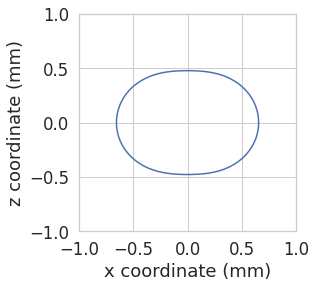

In [ ]:
# Check contours for specific AR values
AR=0.65
row=find_nearest(dataset.AR, AR)[1]

x, y = pol2cart_theta(np.asarray(dataset.iloc[row, 0:900]), np.asarray(dataset.iloc[row, 900:1800]))

plt.figure()
plt.plot(x, y)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')

#### Conditions

In [ ]:
# radius < 1/10 of operating wavelegth 40 kHz
!mkdir -p '/content/drive/My Drive/DropLev/Dataset/' #Ceates a folder named "MachineLearningModels"


wavelength_lim = 343 / 40 # [mm] 
radius=width/2

raw_dataset['radius']=radius
savefig=False

sns.set_theme(style='ticks', font_scale=1.5)

path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/restrictions/')

plt.figure(figsize=(8,6))
plt.plot(raw_dataset.radius[0:100], '-ob', markersize=5, label='In silico data')
plt.plot(range(len(raw_dataset.iloc[0:100, :])), np.repeat(wavelength_lim*0.1, len(raw_dataset.iloc[0:100, :])), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path + 'wavelenght_before_svg', dpi=300, format='svg')
  plt.savefig(path + 'wavelenght_before_png', dpi=300, format='png')

pre_rslt_dataset= raw_dataset[raw_dataset['radius'] < wavelength_lim*0.1]
pre_rslt_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.radius[0:100], '-ob', markersize=5, label='In silico data')
plt.plot(range(len(pre_rslt_dataset.iloc[0:100, :])), np.repeat(wavelength_lim*0.1, len(pre_rslt_dataset.iloc[0:100, :])), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'wavelenght_after_svg', dpi=300, format='svg')
  plt.savefig(path+ 'wavelenght_after_png', dpi=300, format='png')

# Capillary length check
ST_c=np.linspace(25, 74, len(pre_rslt_dataset))
lambda_c=np.sqrt(ST_c/9.81)
volume_c=(4/3)*np.pi*(lambda_c/2)**3

rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['vol'] <= volume_c*0.7]
rslt_dataset.reset_index(drop=True, inplace=True)


plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.ST[0:1000], pre_rslt_dataset.vol[0:1000], 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.plot(ST_c, volume_c*0.7, '--g', label='Capillary lentgh limit at 70%')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_before_cond_0.70_svg', dpi=300, format='svg')
  plt.savefig(path+ 'capillary_length_before_cond_0.70_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.plot(rslt_dataset.ST[0:1000], rslt_dataset.vol[0:1000], 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.plot(ST_c, volume_c*0.7, '--g', label='Capillary lentgh limit at 70%')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_after_cond_0.70_svg', dpi=300, format='svg')
  plt.savefig(path+ 'capillary_length_after_cond_0.70_png', dpi=300, format='png')

#Aspect ratio
Ar_limit=0.66

final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]
final_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))  
plt.plot(rslt_dataset.AR[0:100], '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(rslt_dataset.iloc[0:100, :])), np.repeat(Ar_limit, len(rslt_dataset.iloc[0:100, :])), '--r', label='Maximum deformation limit')
plt.xlabel('Instances',fontsize=18)
plt.ylabel('Aspect ratio', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_before_0.66_cond_svg', dpi=300, format='svg')
  plt.savefig(path+ 'AR_before_0.66_cond_png', dpi=300, format='png')


plt.figure(figsize=(8,6))  
plt.plot(final_dataset.AR[0:100], '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(final_dataset.iloc[0:100, :])), np.repeat(Ar_limit, len(final_dataset.iloc[0:100, :])), '--r', label='Maximum deformation limit')
plt.xlabel('Instances')
plt.ylabel('Aspect ratio')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_after_0.66_cond_svg', dpi=300, format='svg')
  plt.savefig(path+ 'AR_after_0.66_cond_´png', dpi=300, format='png')


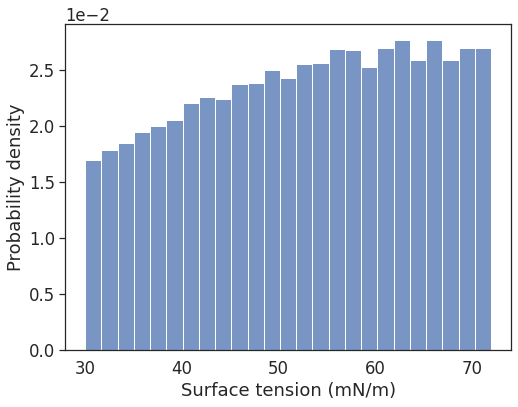

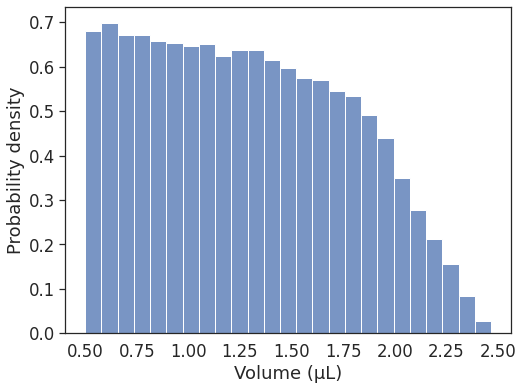

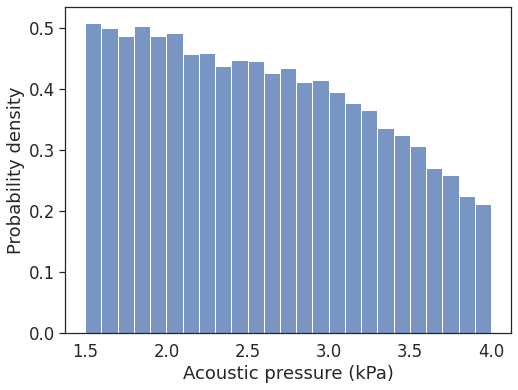

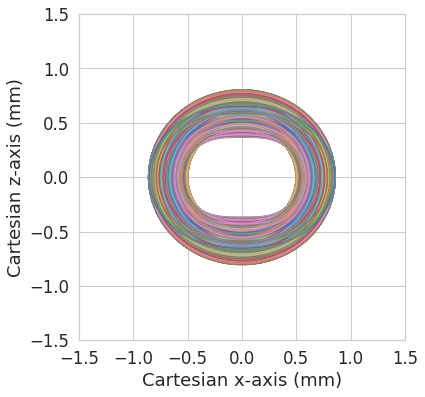

In [ ]:
#New data distribution

dataset=final_dataset.copy()
# dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/In_Silico/raw_dataset_same_theta_after_conditions_900points_more_compr.csv', ';', index=False)


savefig=True
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'ST_theory_after_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'Volume_theory_after_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'Ps_theory_after_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(dataset.iloc[j, 0:sampling]), np.asarray(dataset.iloc[j, sampling:2*sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'contours_theory_after_png', dpi=300, format='png')


# final_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_dataset_after_conditions.csv', ';', index=False)
# raw_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_raw_dataset.csv', ';', index=False)




#### Drop contour points

In [ ]:
# n_dataset=dataset.copy()

# # If we want to drop 150 datapoints then n= 299 

# # If we want to drop 125 datapoints then n= 250
# 6

# n=250
# for i in range(0, n, 2):
#   dataset.pop('theta_%d' %i)

# # for i in range(0, n, 2):
# #   dataset.pop('phi_%d' %i)

# for i in range(0,n, 2):
#   dataset.pop('rho_%d' %i)
# dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST,AR,radius
50423,0.609568,0.609584,0.609610,0.609648,0.609696,0.609755,0.609824,0.609905,0.609996,0.610098,...,3.107102,3.114077,3.121051,3.128026,3.135,1.339101,2440.778163,46.934689,0.845590,0.720867
50424,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301,0.892451,0.686405
50425,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300,0.877662,0.787381
50426,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339,0.834428,0.588568
50427,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363,0.899226,0.692040


In [4]:
#Choosing 175 points with constant phi

sampling=900
points=175
new_phi=np.linspace(-3.13, 3.13, points)

new_rho=[]

### Interpolate to find all the radius for specific theta
for k in range(len(dataset)):
  x, y = pol2cart_theta(dataset.iloc[k, 0:sampling].values, dataset.iloc[k, sampling:2*sampling].values)
  rho, phi=cart2pol(x, y)
  contour_interp=interp1d(phi, rho, kind='slinear')
  new_rho.append(contour_interp(new_phi))

theta = []
theta_array = []
features = pd.DataFrame()

rho_n=[]

for k in range(points):
  rho_n.append(str('row_%d' %k))

features[rho_n]=new_rho

for k in range(points):
  theta.append(str('theta_%d' %k))

x, y = pol2cart(new_rho, new_phi)
theta_array = azimuth(x, y)

features[theta] = theta_array

features_DF=pd.concat([features, dataset.iloc[:, 2*sampling:]], axis=1)

AR=features_DF.pop('AR')
radius=features_DF.pop('radius')
vol=features_DF.pop('vol')
features_DF.tail()


dataset=features_DF.copy()

dataset.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
50423,0.720853,0.720616,0.720093,0.719286,0.718199,0.716837,0.715208,0.713321,0.711185,0.708811,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,2440.778163,46.934689
50424,0.686396,0.686239,0.685892,0.685357,0.684636,0.683733,0.682653,0.681401,0.679984,0.678410,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,2409.976323,63.571301
50425,0.787369,0.787164,0.786711,0.786013,0.785072,0.783894,0.782484,0.780851,0.779002,0.776948,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,2246.471091,59.265300
50426,0.588555,0.588348,0.587890,0.587183,0.586232,0.585039,0.583613,0.581961,0.580090,0.578012,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,3058.148777,50.762339
50427,0.692031,0.691883,0.691555,0.691050,0.690369,0.689515,0.688495,0.687312,0.685974,0.684487,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,1656.011831,32.620363


### Check contours

In [ ]:
dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST,AR,radius
50423,0.609568,0.609584,0.609610,0.609648,0.609696,0.609755,0.609824,0.609905,0.609996,0.610098,...,3.107102,3.114077,3.121051,3.128026,3.135,1.339101,2440.778163,46.934689,0.845590,0.720867
50424,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301,0.892451,0.686405
50425,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300,0.877662,0.787381
50426,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339,0.834428,0.588568
50427,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363,0.899226,0.692040


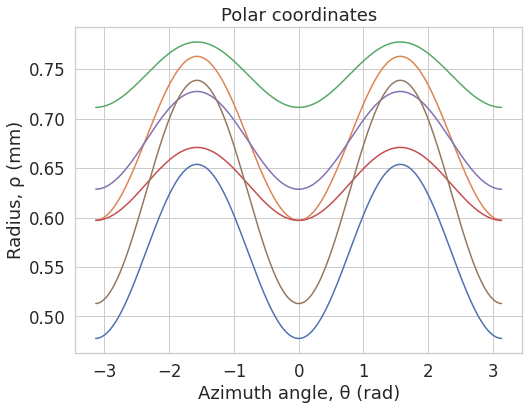

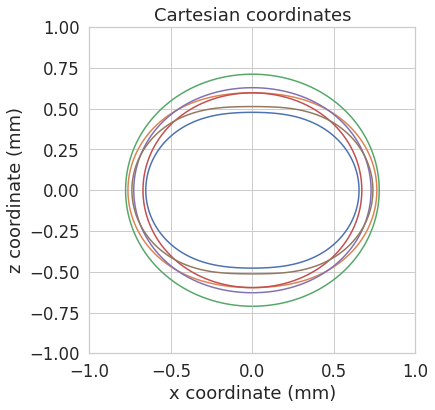

In [ ]:

n=0
rand_cont=np.array([0, 1500, 3000, 5000, 6000, 7500])
savefig=True

points=900

plt.figure(figsize=(8,6))
plt.title('Polar coordinates')
for n in rand_cont:
  plt.plot(dataset.iloc[n, points:2*points], dataset.iloc[n, 0:points])
plt.ylabel('Radius, ρ (mm)')
plt.xlabel('Azimuth angle, θ (rad)')
if savefig==True:
  plt.savefig(path+'polar_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'polar_contours_before_norm_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
for i in rand_cont:
  x, y=pol2cart_theta(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:2*points].values)
  plt.plot(x, y)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'Cart_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'Cart_contours_before_norm_png', dpi=300, format='png')


In [ ]:
#New data distribution
# plt.figure()
# sns.histplot(dataset.ST, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Probability density')

# plt.figure()
# sns.histplot(dataset.vol, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Volume (μL)')
# plt.ylabel('Probability density')

# plt.figure()
# sns.histplot(dataset.Ps, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Acoustic pressure (Pa)')
# plt.ylabel('Probability density')

# fig, ax = plt.subplots()
# plt.xlabel('Cartesian y-axis (mm)')
# plt.ylabel('Cartesian z-axis (mm)')
# ax = plt.gca()
# ax.set_aspect(1)
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
# for j in range(len(dataset)):
#   x,y=pol2cart_theta(np.asarray(dataset.iloc[j, sampling:sampling+sampling]), np.asarray(dataset.iloc[j, 0:sampling]))
#   plt.plot(x, y)





In [ ]:
# ST_1=dataset[(dataset['ST'] <= 72) & (dataset['ST'] > 71.5) ]
# vol_1=ST_1[(ST_1['vol']<=3 ) & (ST_1['vol'] > 2)]

# ST_3=dataset[(dataset['ST'] <= 50.5) & (dataset['ST'] > 50) ]
# vol_3=ST_3[(ST_3['vol']<=3 ) & (ST_3['vol'] > 2)]

# ST_2=dataset[(dataset['ST'] <= 25.5) & (dataset['ST'] > 25) ]
# vol_2=ST_2[(ST_2['vol']<=3 ) & (ST_2['vol'] > 2)]

# plt.figure()
# plt.plot(vol_1.Ps, vol_1.AR, 'o', label='ST=71.25+-0.25')
# plt.plot(vol_3.Ps, vol_3.AR, 'o', label='ST=50.25+-0.25')
# plt.plot(vol_2.Ps, vol_2.AR, 'o', label='ST=25.25+-0.25')
# plt.xlabel('Acoustic pressure (Pa)')
# plt.ylabel('Aspect Ratio')
# plt.legend()


###Import it using pandas for **options 1 and 2**

In [ ]:
column_names=[]

for i in range(100):
  column_names.append('rho_%d' %i)
for i in range(100):
  column_names.append('phi_%d' %i)
for i in range(100):
  column_names.append('cos2theta_%d' %i)
column_names.append('(k*R_sph)^2')
column_names.append('R_sph2')
column_names.append('Ps2*Cg_air')

column_names.append('st')

#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()


#for i in range(100):
#  dataset.pop('cos2theta_%d' %i)

dataset.pop('Ps2*Cg_air')


dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,cos2theta_63,cos2theta_64,cos2theta_65,cos2theta_66,cos2theta_67,cos2theta_68,cos2theta_69,cos2theta_70,cos2theta_71,cos2theta_72,cos2theta_73,cos2theta_74,cos2theta_75,cos2theta_76,cos2theta_77,cos2theta_78,cos2theta_79,cos2theta_80,cos2theta_81,cos2theta_82,cos2theta_83,cos2theta_84,cos2theta_85,cos2theta_86,cos2theta_87,cos2theta_88,cos2theta_89,cos2theta_90,cos2theta_91,cos2theta_92,cos2theta_93,cos2theta_94,cos2theta_95,cos2theta_96,cos2theta_97,cos2theta_98,cos2theta_99,(k*R_sph)^2,R_sph2,st
292,0.594194,0.593489,0.591385,0.587916,0.583138,0.577128,0.569983,0.561817,0.552761,0.542963,0.532578,0.521775,0.510727,0.499611,0.488608,0.477893,0.467640,0.458013,0.449166,0.441244,0.434372,0.428662,0.424205,0.421073,0.419316,0.418964,0.420020,0.422469,0.426271,0.431365,0.437669,0.445081,0.453483,0.462738,0.472698,0.483204,0.494085,0.505166,0.516270,0.527218,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
293,0.595005,0.594291,0.592158,0.588641,0.583796,0.577703,0.570458,0.562178,0.552997,0.543062,0.532534,0.521580,0.510379,0.499109,0.487953,0.477090,0.466694,0.456933,0.447964,0.439931,0.432964,0.427174,0.422655,0.419480,0.417699,0.417341,0.418413,0.420896,0.424751,0.429915,0.436307,0.443822,0.452340,0.461724,0.471822,0.482474,0.493506,0.504741,0.515999,0.527099,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
294,0.595822,0.595098,0.592935,0.589370,0.584459,0.578281,0.570936,0.562543,0.553235,0.543163,0.532489,0.521385,0.510029,0.498604,0.487293,0.476280,0.465741,0.455845,0.446753,0.438609,0.431546,0.425676,0.421095,0.417876,0.416070,0.415708,0.416794,0.419311,0.423219,0.428455,0.434935,0.442554,0.451189,0.460702,0.470940,0.481738,0.492923,0.504313,0.515727,0.526980,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
295,0.596645,0.595910,0.593718,0.590104,0.585126,0.578864,0.571418,0.562909,0.553474,0.543264,0.532444,0.521188,0.509676,0.498094,0.486629,0.475465,0.464782,0.454750,0.445533,0.437278,0.430118,0.424168,0.419524,0.416261,0.414431,0.414063,0.415164,0.417716,0.421678,0.426985,0.433554,0.441277,0.450031,0.459674,0.470052,0.480998,0.492336,0.503882,0.515452,0.526859,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
296,0.597473,0.596729,0.594507,0.590843,0.585797,0.579450,0.571903,0.563279,0.553715,0.543366,0.532399,0.520989,0.509321,0.497582,0.485961,0.474645,0.463816,0.453648,0.444306,0.435938,0.428681,0.422650,0.417943,0.414635,0.412780,0.412407,0.413523,0.416110,0.420125,0.425505,0.432163,0.439991,0.448864,0.458639,0.469158,0.480253,0.491745,0

In [ ]:
k_o=2*np.pi*20.2/340 
dataset['(k*R_sph)^2']=(dataset['(k*R_sph)^2']*k_o)**2

#Cg_air=1/103623.50  #Pa**(-1)
#dataset['Ps2*Cg_air']=dataset['Ps2*Cg_air']*Cg_air

In [ ]:
dataset.iloc[193, :]

rho_0           6.275189e-01
rho_1           6.267880e-01
rho_2           6.246516e-01
rho_3           6.211441e-01
rho_4           6.163220e-01
                    ...     
cos2theta_98    4.021315e-03
cos2theta_99    3.749399e-33
(k*R_sph)^2     4.508115e-02
R_sph2          3.235120e-01
st              2.200000e+01
Name: 193, Length: 303, dtype: float64

### Import data for **option 3**:

In [ ]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

### Shuffle the data

In [5]:
from sklearn.utils import shuffle

dataset=shuffle(dataset, random_state=0)

dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
50423,0.704663,0.704567,0.704356,0.704031,0.703593,0.703043,0.702386,0.701625,0.700763,0.699805,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,1724.775618,59.380928
50424,0.632696,0.632487,0.632025,0.631313,0.630354,0.629152,0.627715,0.626049,0.624164,0.622070,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,3337.331091,71.977815
50425,0.811638,0.811482,0.811138,0.810607,0.809892,0.808996,0.807924,0.806682,0.805276,0.803714,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,1913.779293,63.047806
50426,0.681748,0.681640,0.681402,0.681036,0.680542,0.679923,0.679182,0.678324,0.677353,0.676275,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,1528.620644,37.755653
50427,0.708404,0.707933,0.706892,0.705287,0.703125,0.700415,0.697175,0.693420,0.689170,0.684448,...,-1.307365,-1.343342,-1.379319,-1.415296,-1.451273,-1.48725,-1.523227,-1.559204,3132.627025,32.270707


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [6]:
train_data = dataset.sample(frac=0.8,random_state=1)
test_data = dataset.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [ ]:
# train_stats = train_data.describe()
# train_stats.pop("ST")

# train_stats = train_stats.transpose()
# train_stats

,count,mean,std,min,25%,50%,75%,max
theta_0,40342.0,-1.582389,7.769437e-13,-1.582389,-1.582389,-1.582389,-1.582389,-1.582389
theta_1,40342.0,-1.618366,1.692445e-12,-1.618366,-1.618366,-1.618366,-1.618366,-1.618366
theta_2,40342.0,-1.654343,8.935186e-13,-1.654343,-1.654343,-1.654343,-1.654343,-1.654343
theta_3,40342.0,-1.690320,7.984823e-13,-1.690320,-1.690320,-1.690320,-1.690320,-1.690320
theta_4,40342.0,-1.726297,2.733403e-13,-1.726297,-1.726297,-1.726297,-1.726297,-1.726297
...,...,...,...,...,...,...,...,...
row_171,40342.0,0.699607,9.584425e-02,0.496264,0.621636,0.706821,0.781836,0.859090
row_172,40342.0,0.700439,9.605610e-02,0.496953,0.622327,0.707645,0.782736,0.858653
row_173,40342.0,0.700978,9.619416e-02,0.497608,0.622786,0.708244,0.783318,0.858023
row_174,40342.0,0.701224,9.625689e-02,0.497953,0.623001,0.708497,0.783687,0.857536


### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)
# #normed_train_data = train_dataset
# #normed_test_data = test_dataset


In [ ]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx], idx
    
# find_nearest(train_stats['std'], 0)

(0.0, 193)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Min-Max transformation

In [7]:
#Min-Max transformation

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_theta[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_rho, df_theta], axis=1)

  return new_df


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_theta[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_rho, df_theta], axis=1)

  return new_df


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [8]:
#Scalling training dataset
new_df_train=MinMaxTransformTrain(train_data, points=175)
new_df_train.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174
40337,0.839875,0.839257,0.837892,0.835787,0.832952,0.829398,0.825149,0.820225,0.814652,0.808459,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
40338,0.496303,0.495647,0.494198,0.491962,0.488952,0.485178,0.480666,0.475437,0.469519,0.462943,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
40339,0.413989,0.413585,0.412694,0.411318,0.409466,0.407144,0.404367,0.401150,0.397509,0.393463,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
40340,0.772804,0.772323,0.771260,0.769622,0.767415,0.764649,0.761341,0.757509,0.753171,0.748351,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
40341,0.411204,0.410826,0.409991,0.408703,0.406969,0.404795,0.402195,0.399183,0.395773,0.391985,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344


In [9]:
#Scalling test dataset based on training dataset
new_df_test=MinMaxTransformTest(test_data, train_data, points=175)
new_df_test.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174
10081,0.903407,0.903000,0.902100,0.900712,0.898842,0.896499,0.893697,0.890450,0.886775,0.882692,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
10082,0.677999,0.677310,0.675787,0.673438,0.670275,0.666311,0.661569,0.656076,0.649858,0.642948,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
10083,0.690302,0.689261,0.686958,0.683408,0.678626,0.672633,0.665465,0.657160,0.647761,0.637316,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
10084,0.641303,0.641083,0.640598,0.639849,0.638841,0.637577,0.636066,0.634315,0.632334,0.630132,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344
10085,0.695708,0.694746,0.692622,0.689345,0.684933,0.679402,0.672788,0.665125,0.656451,0.646813,...,0.303174,0.297415,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344


In [ ]:
# sns.set_theme(style='ticks', font_scale=1.5)

# points=175

# plt.figure(figsize=(8,6))
# plt.title('Polar coordinates')
# for n in range(5):
#   plt.plot(new_df_train.iloc[n, points:2*points], new_df_train.iloc[n, 0:points], '-')
#   plt.plot(new_df_test.iloc[n, points:2*points], new_df_test.iloc[n, 0:points], '-')
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')
# # plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/polar_coords_after_transf', dpi=300, format='svg')

In [10]:
points=175

# train_data.pop('radius')
# train_data.pop('AR')
# train_data.pop('vol')

# test_data.pop('radius')
# test_data.pop('AR')
# test_data.pop('vol')

if train_data.shape[1]>2*points:
  stats = train_data.iloc[:, 2*points:].describe() 
else:
  stats = train_data.iloc[:, points:].describe() 
# stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Ps,40342.0,2597.807250,686.920095,1500.007009,2003.218161,2549.140102,3148.926445,3999.981034
ST,40342.0,52.495811,11.789017,30.000614,42.740540,53.123200,62.672681,71.998954


In [11]:
if train_data.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, 2*points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, 2*points:])   #iloc[:, 2*points:]
else:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])   #iloc[:, 2*points:]

In [12]:
#Putting scalled training dataset together
# for i in range(sampling):
#   new_df_train.pop('theta_%d' %i)

normed_train_data = new_df_train.copy()
# normed_train_data['vol'] = normed_train_data_rest.volume
# normed_train_data['Aspect_Ratio'] = normed_train_data_rest.Aspect_Ratio
normed_train_data['Ps'] = normed_train_data_rest.Ps
normed_train_data['ST'] = normed_train_data_rest.ST

normed_train_data.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
40337,0.839875,0.839257,0.837892,0.835787,0.832952,0.829398,0.825149,0.820225,0.814652,0.808459,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.637988,0.955758
40338,0.496303,0.495647,0.494198,0.491962,0.488952,0.485178,0.480666,0.475437,0.469519,0.462943,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.577247,0.021021
40339,0.413989,0.413585,0.412694,0.411318,0.409466,0.407144,0.404367,0.401150,0.397509,0.393463,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.792156,0.812529
40340,0.772804,0.772323,0.771260,0.769622,0.767415,0.764649,0.761341,0.757509,0.753171,0.748351,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.403697,0.588313
40341,0.411204,0.410826,0.409991,0.408703,0.406969,0.404795,0.402195,0.399183,0.395773,0.391985,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.356635,0.057726


In [13]:
#Putting scalled test dataset together

# for i in range(sampling):
#   new_df_test.pop('theta_%d' %i)

normed_test_data = new_df_test.copy()
# normed_test_data['vol'] = normed_test_data_rest.volume
# normed_test_data['Aspect_Ratio'] = normed_test_data_rest.Aspect_Ratio
normed_test_data['Ps'] = normed_test_data_rest.Ps
normed_test_data['ST'] = normed_test_data_rest.ST

normed_test_data.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
10081,0.903407,0.903000,0.902100,0.900712,0.898842,0.896499,0.893697,0.890450,0.886775,0.882692,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.214653,0.576340
10082,0.677999,0.677310,0.675787,0.673438,0.670275,0.666311,0.661569,0.656076,0.649858,0.642948,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.614664,0.341452
10083,0.690302,0.689261,0.686958,0.683408,0.678626,0.672633,0.665465,0.657160,0.647761,0.637316,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.906110,0.275340
10084,0.641303,0.641083,0.640598,0.639849,0.638841,0.637577,0.636066,0.634315,0.632334,0.630132,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.011446,0.184651
10085,0.695708,0.694746,0.692622,0.689345,0.684933,0.679402,0.672788,0.665125,0.656451,0.646813,...,0.291656,0.285897,0.280138,0.274379,0.26862,0.262862,0.257103,0.251344,0.653055,0.054052


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

### Alternating rho, theta

In [ ]:
# Normed training data
rho=normed_train_data.iloc[:, 0:175]
theta=normed_train_data.iloc[:, 175:2*175]

norder=pd.DataFrame()
for i in range(175):
  norder = norder.append(rho.iloc[:, i])
  norder = norder.append(theta.iloc[:, i])

norder=norder.T

# norder['Ps']=dataset['Ps']
# norder['ST']=dataset['ST']
norder.tail()

,rho_0,theta_0,rho_1,theta_1,rho_2,theta_2,rho_3,theta_3,rho_4,theta_4,rho_5,theta_5,rho_6,theta_6,rho_7,theta_7,rho_8,theta_8,rho_9,theta_9,rho_10,theta_10,rho_11,theta_11,rho_12,theta_12,rho_13,theta_13,rho_14,theta_14,rho_15,theta_15,rho_16,theta_16,rho_17,theta_17,rho_18,theta_18,rho_19,theta_19,...,rho_155,theta_155,rho_156,theta_156,rho_157,theta_157,rho_158,theta_158,rho_159,theta_159,rho_160,theta_160,rho_161,theta_161,rho_162,theta_162,rho_163,theta_163,rho_164,theta_164,rho_165,theta_165,rho_166,theta_166,rho_167,theta_167,rho_168,theta_168,rho_169,theta_169,rho_170,theta_170,rho_171,theta_171,rho_172,theta_172,rho_173,theta_173,rho_174,theta_174
40498,0.417855,0.001771,0.417978,0.007267,0.418256,0.012893,0.419308,0.024447,0.419469,0.025769,0.419686,0.027455,0.419718,0.027695,0.423587,0.049047,0.424644,0.053537,0.426269,0.059877,0.426315,0.060048,0.431856,0.078571,0.438594,0.097827,0.442124,0.107210,0.443271,0.110198,0.444182,0.112558,0.447153,0.120184,0.448896,0.124633,0.449126,0.125221,0.449312,0.125697,...,0.442421,0.892015,0.439475,0.899800,0.439191,0.900562,0.433544,0.916371,0.433313,0.917051,0.431031,0.923977,0.430391,0.925995,0.429124,0.930108,0.427503,0.935647,0.426409,0.939602,0.426375,0.939728,0.426098,0.940762,0.424747,0.946043,0.421165,0.962967,0.420990,0.963973,0.418929,0.978986,0.418661,0.981789,0.418268,0.986924,0.417952,0.993489,0.417879,0.996411
40499,0.589203,0.002689,0.589801,0.006750,0.590037,0.007794,0.591951,0.013559,0.608796,0.035847,0.622927,0.047269,0.626629,0.049871,0.627171,0.050242,0.657389,0.068246,0.667563,0.073518,0.669927,0.074705,0.673337,0.076395,0.722566,0.098718,0.740200,0.106120,0.749858,0.110101,0.770312,0.118420,0.777297,0.121240,0.792947,0.127546,0.830009,0.142620,0.859765,0.155182,...,0.673591,0.923480,0.669719,0.925399,0.668219,0.926151,0.666674,0.926931,0.664503,0.928038,0.660138,0.930301,0.659059,0.930869,0.658536,0.931145,0.658341,0.931248,0.657523,0.931683,0.656563,0.932195,0.646496,0.937758,0.641909,0.940425,0.619621,0.955166,0.617890,0.956490,0.609629,0.963390,0.601792,0.971308,0.600077,0.973336,0.589540,0.994632,0.589133,0.998343
40500,0.573368,0.002448,0.573633,0.005390,0.580382,0.024897,0.581568,0.026919,0.588477,0.036619,0.597473,0.046464,0.609259,0.057084,0.626371,0.070118,0.632991,0.074692,0.633474,0.075018,0.640551,0.079691,0.641888,0.080554,0.660191,0.091861,0.660506,0.092048,0.666540,0.095609,0.677002,0.101645,0.699164,0.114030,0.700832,0.114948,0.704662,0.117050,0.705006,0.117239,...,0.746405,0.860084,0.729738,0.869256,0.714257,0.877704,0.692574,0.889611,0.692115,0.889866,0.668039,0.903516,0.656610,0.910287,0.653621,0.912102,0.650830,0.913815,0.643033,0.918712,0.639450,0.921024,0.634674,0.924176,0.634312,0.924419,0.631003,0.926660,0.597396,0.953612,0.589290,0.962395,0.587662,0.964395,0.586723,0.965598,0.583193,0.970527,0.573328,0.998402
40501,0.175875,0.001256,0.175877,0.001318,0.176021,0.003659,0.176087,0.004332,0.176456,0.006985,0.177047,0.009840,0.177405,0.011222,0.178811,0.015513,0.179637,0.017555,0.180485,0.019432,0.188734,0.032558,0.189258,0.033222,0.196349,0.041244,0.211477,0.054849,0.213636,0.056559,0.215711,0.058163,0.224198,0.064382,0.225129,0.065035,0.236571,0.072702,0.238373,0.073856,...,0.295098,0.893944,0.286206,0.898647,0.284103,0.899771,0.262319,0.911778,0.251024,0.918356,0.242695,0.923424,0.230394,0.931358,0.228597,0.932573,0.224697,0.935267,0.216701,0.941085,0.198706,0.956390,0.191383,0.964198,0.183738,0.974599,0.179076,0.983805,0.178378,0.985672,0.176886,0.990848,0.176681,0.991810,0.175948,0.997254,0.175879,0.998619,0.175879,0.998625
40502,0.537671,0.003901,0.537775,0.004602,0.537806,0.004787,0.540982,0.014320,0.545277,0.021277,0.547468,0.024076,0.549416,0.026323,0.553229,0.030258,0.554608,0.031565,0.556830,0.033571,0.559680,0.035989,0.570301,0.043919,0.581245,0.050925,0.606367,0.064541,0.631176,0.076078,0.662887,0.089307,0.677151,0.094903,0.680890,0.096343,0.682944,0.097130,0.689643,0.099677,...,0.763382,0.873413,0.750339,0.878099,0.707732,

In [ ]:
normed_train_data=norder.copy()

In [ ]:
normed_train_data['Ps']=normed_train_data_rest.Ps

In [ ]:
# Normed test data
rho=normed_test_data.iloc[:, 0:175]
theta=normed_test_data.iloc[:, 175:2*175]

norder=pd.DataFrame()
for i in range(175):
  norder = norder.append(rho.iloc[:, i])
  norder = norder.append(theta.iloc[:, i])


norder=norder.T

# norder['Ps']=dataset['Ps']
# norder['ST']=dataset['ST']
norder.tail()

,rho_0,theta_0,rho_1,theta_1,rho_2,theta_2,rho_3,theta_3,rho_4,theta_4,rho_5,theta_5,rho_6,theta_6,rho_7,theta_7,rho_8,theta_8,rho_9,theta_9,rho_10,theta_10,rho_11,theta_11,rho_12,theta_12,rho_13,theta_13,rho_14,theta_14,rho_15,theta_15,rho_16,theta_16,rho_17,theta_17,rho_18,theta_18,rho_19,theta_19,...,rho_155,theta_155,rho_156,theta_156,rho_157,theta_157,rho_158,theta_158,rho_159,theta_159,rho_160,theta_160,rho_161,theta_161,rho_162,theta_162,rho_163,theta_163,rho_164,theta_164,rho_165,theta_165,rho_166,theta_166,rho_167,theta_167,rho_168,theta_168,rho_169,theta_169,rho_170,theta_170,rho_171,theta_171,rho_172,theta_172,rho_173,theta_173,rho_174,theta_174
10121,0.747926,0.001181,0.747975,0.002665,0.749121,0.011920,0.749158,0.012100,0.749167,0.012143,0.749644,0.014276,0.750958,0.018961,0.752990,0.024524,0.752994,0.024533,0.753051,0.024672,0.753294,0.025253,0.756505,0.031993,0.756833,0.032606,0.757904,0.034538,0.758190,0.035038,0.759008,0.036429,0.761459,0.040333,0.762190,0.041431,0.767357,0.048557,0.767875,0.049221,...,0.870650,0.863887,0.866471,0.866996,0.860685,0.871282,0.860214,0.871630,0.852745,0.877148,0.851152,0.878325,0.847530,0.881005,0.830802,0.893522,0.826980,0.896437,0.794519,0.923016,0.792706,0.924654,0.788884,0.928190,0.784731,0.932179,0.781542,0.935365,0.775599,0.941654,0.769869,0.948294,0.762546,0.958042,0.758130,0.965067,0.752078,0.977806,0.748894,0.989263
10122,0.366119,0.000145,0.366482,0.007699,0.366786,0.010443,0.368138,0.018197,0.369199,0.022502,0.369341,0.023018,0.369706,0.024296,0.369955,0.025133,0.370773,0.027709,0.370951,0.028240,0.372590,0.032738,0.378429,0.045453,0.380966,0.050062,0.382023,0.051877,0.385989,0.058257,0.387846,0.061054,0.391810,0.066710,0.409416,0.088594,0.414968,0.094830,0.417889,0.098032,...,0.438259,0.880558,0.426395,0.892877,0.426074,0.893214,0.404047,0.917675,0.393855,0.930510,0.387620,0.939281,0.386183,0.941445,0.381521,0.948978,0.379672,0.952239,0.378465,0.954480,0.377551,0.956242,0.376060,0.959264,0.373003,0.966218,0.372687,0.967013,0.372586,0.967271,0.372479,0.967548,0.371346,0.970617,0.369541,0.976274,0.366983,0.988113,0.366226,0.995821
10123,0.522310,0.015996,0.522350,0.016588,0.525737,0.044338,0.525781,0.044591,0.530666,0.067620,0.530875,0.068464,0.532177,0.073558,0.533118,0.077087,0.533950,0.080125,0.537212,0.091408,0.537996,0.094006,0.540226,0.101221,0.543531,0.111572,0.544490,0.114525,0.547750,0.124482,0.549867,0.130932,0.551923,0.137234,0.552525,0.139095,0.556467,0.151510,0.557125,0.153640,...,0.534787,0.916895,0.533021,0.923271,0.532884,0.923777,0.532200,0.926354,0.532186,0.926408,0.531497,0.929067,0.531046,0.930849,0.530023,0.935025,0.529802,0.935952,0.528641,0.941016,0.527277,0.947457,0.527062,0.948534,0.526735,0.950211,0.526543,0.951216,0.525982,0.954272,0.525767,0.955491,0.525212,0.958780,0.524744,0.961758,0.522228,0.985317,0.522128,0.987078
10124,0.209693,0.002174,0.209983,0.005787,0.210429,0.008820,0.210616,0.009817,0.211030,0.011726,0.211039,0.011766,0.211266,0.012691,0.211340,0.012976,0.217181,0.027476,0.217826,0.028640,0.221254,0.034195,0.227457,0.042537,0.229494,0.044967,0.254385,0.068733,0.257007,0.070858,0.274579,0.084117,0.279966,0.087922,0.290431,0.095071,0.294095,0.097511,0.320430,0.114437,...,0.318621,0.886702,0.309764,0.892315,0.298617,0.899513,0.296592,0.900841,0.272840,0.917133,0.253398,0.932080,0.246550,0.937936,0.244916,0.939398,0.243903,0.940318,0.239645,0.944321,0.236553,0.947385,0.234794,0.949196,0.230618,0.953741,0.225053,0.960503,0.220484,0.966975,0.219711,0.968191,0.217777,0.971447,0.214304,0.978439,0.211664,0.985834,0.211328,0.987067
10125,0.530432,0.007417,0.530556,0.009034,0.530746,0.011059,0.531450,0.016544,0.531724,0.018242,0.532823,0.023885,0.533108,0.025148,0.534538,0.030733,0.538609,0.042986,0.540280,0.047169,0.546133,0.059809,0.549896,0.066887,0.552759,0.071911,0.553801,0.073677,0.557011,0.078945,0.560216,0.083988,0.561931,0.086611,0.566980,0.094095,0.569714,0.098025,0.573970,0.104015,...,0.575652,0.893654,0.567586,0.905027,0.566139,

In [ ]:
normed_test_data=norder.copy()

In [ ]:
normed_test_data['Ps']=normed_test_data_rest.Ps

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
# from numpy.random import seed

# sseed=10
# def build_model():
#   seed(sseed)
#   tf.random.set_seed(sseed)
#   model = keras.Sequential([
#     layers.Dense(40, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]),
#     layers.Dense(25, activation=tf.nn.softplus),
#     layers.Dense(5, activation=tf.nn.softplus),
#     layers.Dense(1)
#   ])

#   optimizer = tf.keras.optimizers.Adam() 


#   model.compile(loss='mean_absolute_error',
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
#   return model

In [15]:
from numpy.random import seed

sseed=10

def build_model(sseed=sseed):
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [16]:
model = build_model(sseed=sseed)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                17600     
                                                                 
 dense_1 (Dense)             (None, 40)                2040      
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 5)                 5


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[-0.13009004],
       [-0.13030638],
       [-0.13002698],
       [-0.12998874],
       [-0.13014276],
       [-0.12998962],
       [-0.12974533],
       [-0.1299473 ],
       [-0.12977262],
       [-0.13012095]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [19]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



.........................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
52,0.000977,0.017778,0.000977,0.000213,0.012324,0.000213,52
53,0.000237,0.010156,0.000237,0.000193,0.011865,0.000193,53
54,0.000406,0.012774,0.000406,0.000184,0.011062,0.000184,54
55,0.000465,0.013329,0.000465,0.000121,0.007507,0.000121,55
56,0.000567,0.014103,0.000567,0.000154,0.010071,0.000154,56


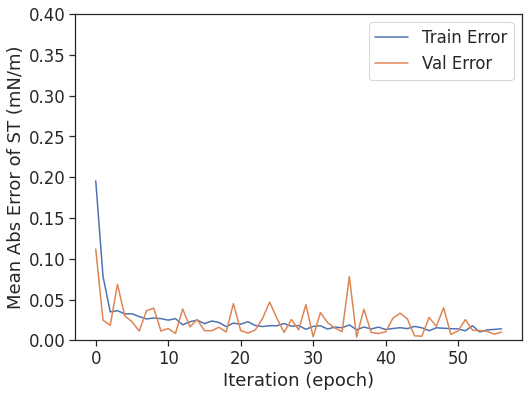

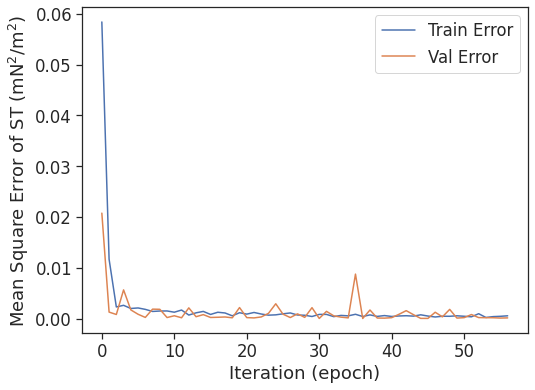

In [21]:
def plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_', dpi=300, format='png')
    plt.savefig(path+'training_outcome_MAE_', dpi=300, format='svg')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_', dpi=300, format='png')
    plt.savefig(path+'training_outcome_MSE_', dpi=300, format='svg')

  plt.show()


plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
# loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

# print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


### Make predictions

Finally, predict ST values using data in the testing set:

In [22]:
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm


def density_scatter(x, y, title=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(7,7)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  plt.title(title)
  im=ax.scatter(x, y, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')
  cbar.ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))



In [23]:
## Re-scale target feature
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=rescaling(test_labels)
ST_pred_test=rescaling(test_predictions)

ST_real_train=rescaling(train_labels)
ST_pred_train=rescaling(train_predictions)  

#Re-scalling check:
# plt.figure(figsize=(8,6))
# plt.scatter(range(len(test_labels)), test_labels)
# plt.ylabel('Normalizaed surface tension')
# plt.xlabel('Instances')

# plt.figure(figsize=(8,6))
# plt.scatter(range(len(ST_real_test)), ST_real_test)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Instances')

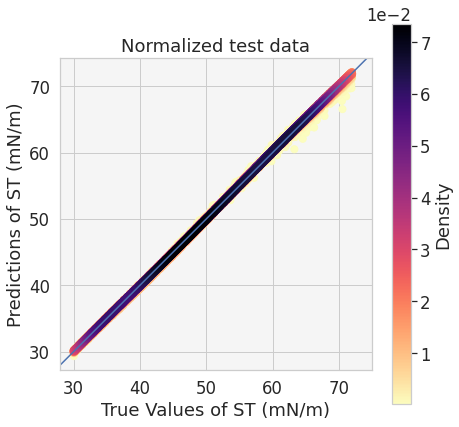

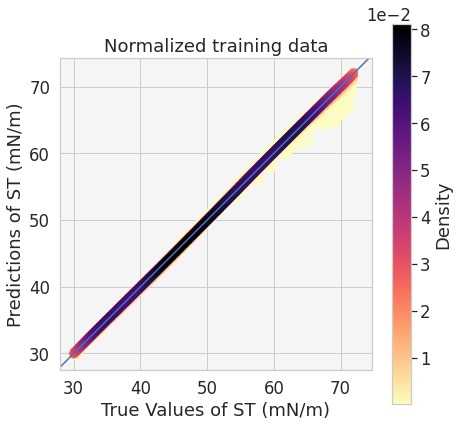

In [24]:

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

sns.set_theme(style='whitegrid', font_scale=1.5)

density_scatter(ST_real_test, ST_pred_test, title='Normalized test data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_test_data_', dpi=300, format='png')
  plt.savefig(path+'error_plot_test_data_', dpi=300, format='svg')


density_scatter(ST_real_train, ST_pred_train, title='Normalized training data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_training_data_', dpi=300, format='png')
  plt.savefig(path+'error_plot_training_data_', dpi=300, format='svg')


Seriously?

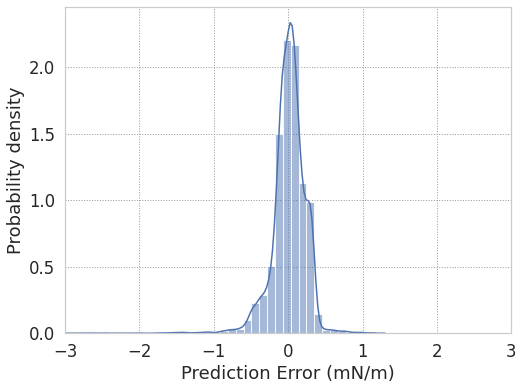

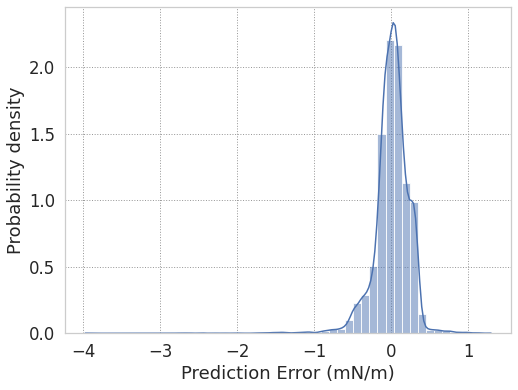

In [25]:
error_test = ST_pred_test - ST_real_test
savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_lim_', dpi=300, format='png')
  plt.savefig(path+'error_distrib_test_data_lim_', dpi=300, format='svg')

plt.show()


plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
# plt.xticks(np.arange(-0.1, 0.15, step=0.05), [-0.1 , -0.05,  0.  ,  0.05,  0.1])
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_', dpi=300, format='png')
  plt.savefig(path+'error_distrib_test_data_', dpi=300, format='svg')

plt.show()

In [26]:
#Confidence:

error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]

mae=sum(abs(error_test_test))/len(error_test_test)
print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %mae)

Confidence for error ± 0.5 mN/m: 96.00 %
Confidence for error ± 1 mN/m: 99.00 %
Confidence for error ± 2 mN/m: 99.00 %
Mean Absolute error: 0.16 mN/m


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

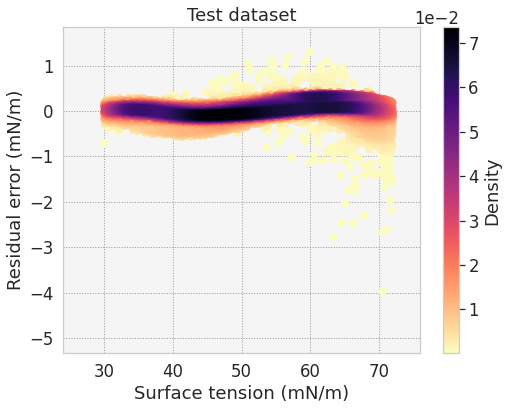

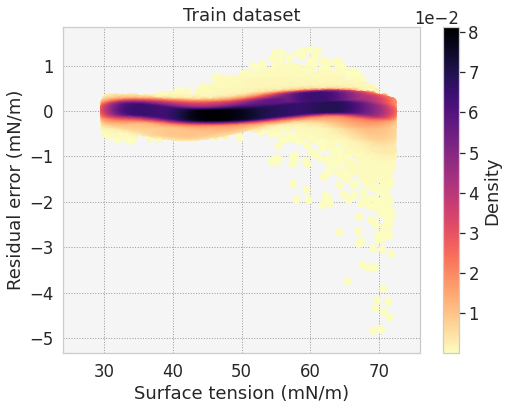

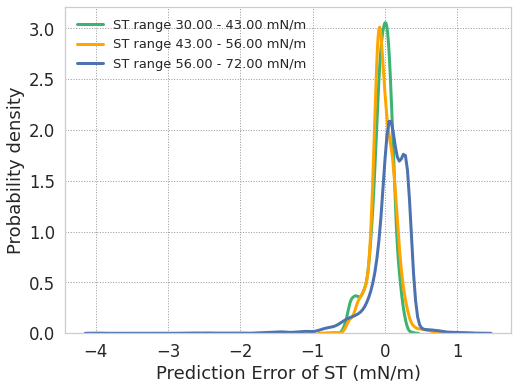

In [27]:
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
savefig=False
figtype='png'

density_scatter(ST_real_test, error_test, title='Test dataset',  eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.gca().invert_xaxis()
plt.xlim(25-1, 75+1)
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_test_data_'+figtype, dpi=300, format=figtype)


density_scatter(ST_real_train, error_train, title='Train dataset', eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.gca().invert_xaxis()
plt.xlim(25-1, 75+1)
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_training_data_'+figtype, dpi=300, format=figtype)



check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]

thickness=3

plt.figure(figsize=(8,6))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'test_data_error_distr_steps_'+figtype, dpi=300, format=figtype)


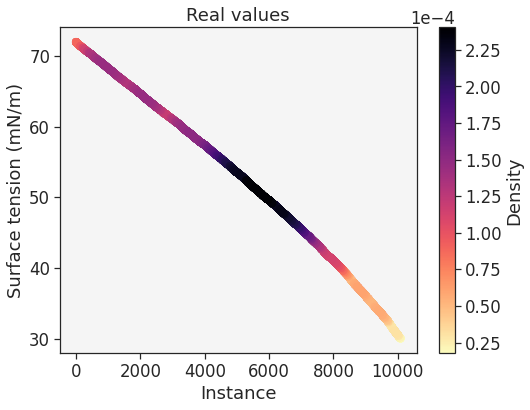

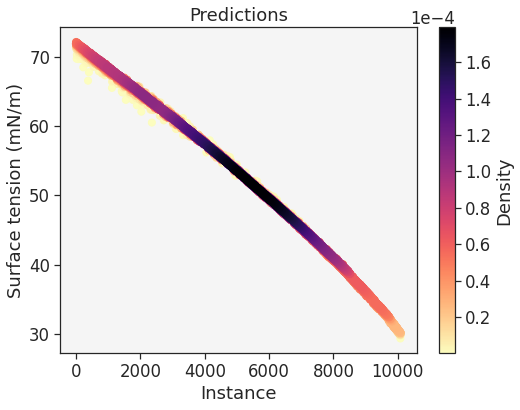

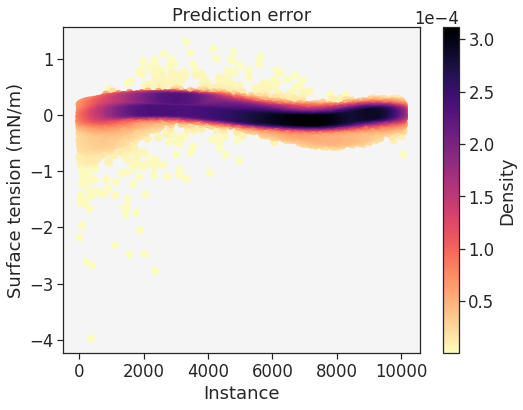

In [28]:
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='svg'
savefig=False

check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

sns.set_theme(style='ticks', font_scale=1.5)


density_scatter(range(len(sorted_st)), sorted_st.True_values,title='Real values',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_real_test_data_'+figtype, dpi=300, format=figtype)


density_scatter(range(len(sorted_st)), sorted_st.Predictions, title='Predictions',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_test_data_'+figtype, dpi=300, format=figtype)

density_scatter(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values,title='Prediction error',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_error_test_data_'+figtype, dpi=300, format=figtype)


### Feature importance

In [29]:
from sklearn.utils import shuffle

#Define number of features/columns
featureNum=normed_test_data.shape[1]

#Define feature/column names
ColumnName=normed_test_data.columns

#Rescalling test labels
ST_real_test=rescaling(test_labels)

#Define a dictionary to save the error
error_test={}
MAE={}
Conf_05={}
Conf_1={}
Conf_2={}

for i in range(featureNum):
  feature=normed_test_data.iloc[:, i]

  for j in range(0, 99, 33):
    # seed(j)

    #Shuffle one feature j times
    shuffled_feature=shuffle(feature, random_state=j)
    #Reset the indexes of the new column
    shuffled_feature.reset_index(drop=True, inplace=True)

    #Copy the normalized test Dataframe into a new Dataframe
    shuffled_test=normed_test_data.copy()

    #Replace feature with shuffled feature
    shuffled_test[ColumnName[i]]=shuffled_feature

    #Predict on the test data with the shuffled feature
    test_predictions = model.predict(shuffled_test).flatten()

    #Rescalling test predictions with shuffled feature
    ST_pred_test=rescaling(test_predictions)

    error_test[i, j] = ST_real_test - ST_pred_test

    MAE[i, j]=sum(abs(error_test[i, j]))/len(error_test[i, j])

    rows_05=error_test[i, j][(error_test[i, j] >= -0.5) & (error_test[i, j] <= 0.5)]
    rows_1=error_test[i, j][(error_test[i, j] >= -1) & (error_test[i, j] <= 1)]
    rows_2=error_test[i, j][(error_test[i, j] >= -2) & (error_test[i, j] <= 2)]

    Conf_05[i, j]=int(len(rows_05)/len(error_test[i, j])*100)
    Conf_1[i, j]=int(len(rows_1)/len(error_test[i, j])*100)
    Conf_2[i, j]=int(len(rows_2)/len(error_test[i, j])*100)






In [30]:
trial=pd.DataFrame.from_dict(MAE, orient='index')

trial=np.asarray(trial, dtype=object)

j=0
Mean=[]
Min=[]
Max=[]
step=int(len(trial)/featureNum)
for i in range(featureNum):
  Mean.append(np.mean(trial[j:j+step]))
  Min.append(min(trial[j:j+step]))
  Max.append(max(trial[j:j+step]))
  j=j+step



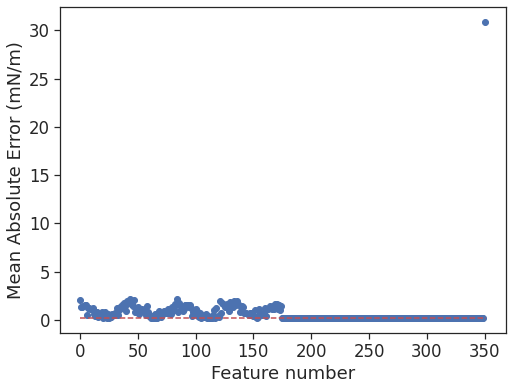

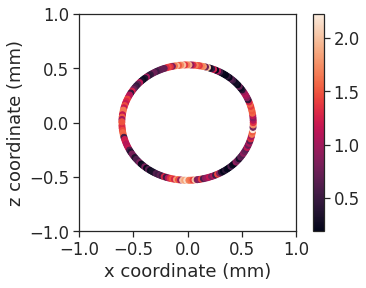

In [32]:
import matplotlib
savefig=True

# xticks=[0, 158, 174, 175, 249, 349, 350, 351]
# xticksnames=ColumnName[xticks]

plt.figure(figsize=(8, 6))
plt.plot(range(featureNum), Mean, 'o')
plt.plot(range(featureNum+1), np.repeat(mae, featureNum+1), 'r--')
# plt.xticks(xticks, xticksnames, rotation=90)
plt.xlabel('Feature number')
plt.ylabel('Mean Absolute Error (mN/m)')
# plt.xlim(175, 349.5)
# plt.ylim(0.1, 0.2)
if savefig==True:
  plt.savefig(path+'features_Vs_MAE_theory_svg', dpi=300, format='svg')
  plt.savefig(path+'features_Vs_MAE_theory_png', dpi=300, format='png')


# theta=raw_dataset.iloc[:, 175:350]

# for i in range(80,160, 1):
#   theta.pop('theta_%d' %i)

z_min=min(Mean[0:95])
z_max=max(Mean[0:95])
fig, ax=plt.subplots()
norm=matplotlib.colors.Normalize(z_min, z_max) #vmin=min(data.Z_center), vmax=max(data.Z_center)
x, y=pol2cart_theta(test_data.iloc[1000, 0:175].values,test_data.iloc[1000, 175:350].values)
im=plt.scatter(x,y, c=Mean[0:175], norm=norm)
plt.colorbar(im, ax=ax)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'feature_importance_coloured_coords_theory_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_coloured_coords_theory_png', dpi=300, format='png')

# plt.figure()
# for i in range(featureNum):
#   plt.errorbar(x=i, y=Mean[i], yerr=(Max[i]-Min[i]))
# plt.ylim(0.7, 1.5)

### Tilting 

In [ ]:
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm
from sklearn.utils import shuffle

from numpy.random import seed

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(train_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

def build_model():
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    # layers.Dense(25, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')



def plot_history(hist, savefig=False, figtype='svg', path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_'+figtype, dpi=300, format=figtype)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_'+figtype, dpi=300, format=figtype)
  plt.show()

def density_scatter(x, y, title=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(7,7)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  plt.title(title)
  im=ax.scatter(x, y, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')
  cbar.ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

def rescaling(target):
  min=stats.loc['ST']['min']
  max=stats.loc['ST']['max']
  target=np.asarray(target)
  return (max-min)*(target)+min

In [ ]:
#Tilting
sns.set_theme(style='ticks', font_scale=1.5)
dataset900=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')


sampling=900 
degree2rad=np.pi/180

restrict_Ar=False

if restrict_Ar==True:
  datasetARrestr=dataset900[dataset900.AR<0.75]
  datasetARrestr.reset_index(drop=True, inplace=True)
  dataset900=datasetARrestr.copy()

num_sample=len(dataset900)  # number of different ST values

angles=np.array([0, 5, 10, 15, 20, 25]) #
points=175
new_phi=np.linspace(-3.13, 3.13, points)
rows_05_all={}
rows_1_all={}
rows_2_all={}
mae_all={}

for i in range(len(angles)):
  min_val, max_val = -angles[i]*degree2rad, angles[i]*degree2rad
  range_size = (max_val - min_val)  
  np.random.seed(i)
  angle=np.random.rand(num_sample) * range_size + min_val
  # angle=angles[i]
  x, y=pol2cart_theta(dataset900.iloc[:, 0:sampling].values, dataset900.iloc[:, sampling:sampling*2].values)

  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[:, np.newaxis], x) - np.multiply(np.sin(angle)[:, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[:, np.newaxis], x) + np.multiply(np.cos(angle)[:, np.newaxis], y)
  # rot_x=np.cos(angle)*x-np.sin(angle)*y
  # rot_y=np.sin(angle)*x+np.cos(angle)*y

  #Choosing 175 points with constant phi

  new_rho=[]

  rot_rho, rot_phi = cart2pol(rot_x, rot_y)
  ### Interpolate to find all the radius for specific theta
  for k in range(len(dataset900)):
    contour_interp=interp1d(rot_phi[k], rot_rho[k], kind='slinear')
    new_rho.append(contour_interp(new_phi))

  theta = []
  theta_array = []
  features = pd.DataFrame()

  # for k in range(points):
  #   theta.append(str('theta_%d' %k))

  x, y = pol2cart(new_rho, new_phi)
  # theta_array = azimuth(x, y)

  # features[theta] = theta_array

  rho_n=[]

  for k in range(points):
    rho_n.append(str('row_%d' %k))

  features[rho_n]=new_rho

  features_DF=pd.concat([features, dataset900.iloc[:, 2*sampling:]], axis=1)

  AR=features_DF.pop('AR')
  radius=features_DF.pop('radius')
  vol=features_DF.pop('vol')
  features_DF.tail()


  dataset=features_DF.copy()

  dataset=shuffle(dataset, random_state=0)

  dataset=dataset.reset_index()
  dataset.pop('index')


  train_data = dataset.sample(frac=0.8,random_state=1)
  test_data = dataset.drop(train_data.index)

  train_data.reset_index(drop=True, inplace=True)
  test_data.reset_index(drop=True, inplace=True)

  #Scalling training dataset
  new_df_train=MinMaxTransformTrain(train_data, points=175)

  #Scalling test dataset based on training dataset
  new_df_test=MinMaxTransformTest(test_data, train_data, points=175)

  stats = train_data.iloc[:, points:].describe()
  stats = stats.transpose()
  stats

  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:])
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])

  normed_train_data = new_df_train.copy()
  normed_train_data['Ps'] = normed_train_data_rest.Ps
  normed_train_data['ST'] = normed_train_data_rest.ST

  normed_test_data = new_df_test.copy()
  normed_test_data['Ps'] = normed_test_data_rest.Ps
  normed_test_data['ST'] = normed_test_data_rest.ST

  train_labels = normed_train_data.pop('ST')
  test_labels = normed_test_data.pop('ST')
  for j in range(6):
    
    sseed=j

    model = build_model()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    ## Re-scale target feature
    test_predictions = model.predict(normed_test_data).flatten()
    train_predictions = model.predict(normed_train_data).flatten()

    ST_real_test=rescaling(test_labels)
    ST_pred_test=rescaling(test_predictions)

    ST_real_train=rescaling(train_labels)
    ST_pred_train=rescaling(train_predictions)  

    error_test = ST_pred_test - ST_real_test
    error_test_test=np.asarray(error_test)

    rows_05=(error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)])
    rows_1=(error_test_test[(error_test_test >= -1) & (error_test_test <= 1)])
    rows_2=(error_test_test[(error_test_test >= -2) & (error_test_test <= 2)])

    rows_05_all[i,j]=len(rows_05)/len(error_test)

    rows_1_all[i,j]=len(rows_1)/len(error_test)

    rows_2_all[i,j]=len(rows_2)/len(error_test)

    mae_all[i,j]=(sum(abs(error_test_test))/len(error_test_test))


    hist.to_csv(path+'history_tilting_%.2f_rep_%d_MAE_%.2f_' %(angles[i], j, mae_all[i, j]) +date)

    tilt_training_outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])
    tilt_training_outcome_test.to_csv(path+'tilt_training_outcome_test_degree_%.2f_rep_%d_' %(angles[i], j) + date, index=False)  #Saves the file
    tilt_training_outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=[ 'Train_labels', 'Train_pred'])
    tilt_training_outcome_train.to_csv(path+'tilt_training_outcome_train_degree_%.2f_rep_%d_' %(angles[i], j) + date, index=False)  #Saves the file




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



......................................................

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



................................................................................................
............................................................
........................................................
................................................................
.................................................................
...................................................
.....................................................
...........................................
................................................................................
.............................................
.....................................................................
........................................................................................
...................................................................
....................................................................................................
.......
........................................

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

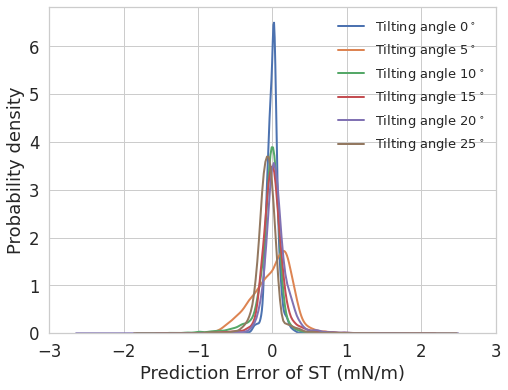

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')
thickness=2
angles=np.array([0, 5, 10, 15, 20, 25])
savefig=False

plt.figure(figsize=(8,6))
for i in range(len(angles)):
  error_test_tilt=[]
  for j in range(6):
    file1=pd.read_csv(path+'tilt_training_outcome_test_degree_%.2f_rep_%d_' %(angles[i], j) + date)
    error_test_tilt.append(file1.Test_labels-file1.Test_pred)
    average_error=[np.mean(k) for k in zip(*error_test_tilt)]
  sns.distplot(average_error, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Tilting angle %d$^\circ$' %angles[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.xlim(-3, 3)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_tilt_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_tilt_png_'+date, dpi=300, format='png')

In [ ]:
data = list(mae_all.items())
an_array = np.array(data)
Mae_values=an_array[:, 1][:]
Mae_avg=[]
j=0
for i in range(int(len(mae_all)/5)):
  Mae_avg.append(np.mean(Mae_values[j:j+5]))
  j=j+5
# plt.figure()
#   plt.plot(mae_all[i, :])

Mae_values

In [ ]:
# Angles: 0, 2.5, 5, 7.5, 10, 12.5, 15 degrees, 8 repeatitions
Mae_values=np.array([0.10616381226262234, 0.12030683607052836, 0.14178589222914784,
       0.30820111161541663, 0.14370443628567436, 0.13296550488663494,
   0.2062324713001694, 0.19262054171882562,
  0.08974273751912833, 0.12707257345685455, 0.1226461571186168, 0.14413354427957373,
       0.10819954151173279, 0.164806897552572, 0.09596656605708821,
       0.10721923374168052,
  0.22243391282283273, 0.20798209380438618,0.2404041904036437, 0.2340680093653085, 0.3360511674040891,
       0.261820710590086, 0.22586934085228114, 0.23141765866417432,
       0.49513342331534027, 0.13171693274184865, 0.43869527356607807,
       0.3408223996310063, 0.1759376671913912, 0.47927324611525934, 0.4491333499257627, 0.33027013220669665,
  0.18235397089836047,0.3058116194941157, 0.2721239388498661, 0.7963661375865706,
       0.3985024066983419, 0.1674622665085432, 0.35623224327275455,
       0.18248915427365628, 
  0.27899569243957756, 0.15245511881591953,0.21079535866552573, 0.12102539945139677, 0.22666030572770132,
       0.17246608719101134, 0.14355976509334142, 0.2602968466793655,
       0.2015099808834237, 0.21214653996076013, 0.3655475431752513,
       0.2889422005522914, 0.19293409982368448, 0.22383213294880164, 0.22653650205547474, 0.11288886608844907])

#Angles 0, 5, 10 15, 20, 25, 6 repeatitions
Mae_values=np.array([0.147774836527493, 0.15971053106224264, 0.09834650324055873,
       0.08518417564811635, 0.11728715358404779, 0.08290211629713364,
       0.3207858605527232, 0.23166505660752978, 0.26209964671368036,
       0.2461897511014339, 0.254166795302288, 0.2339903155891806,
       0.1860999667778659, 0.16048388492737622, 0.4720950580308106,
       0.19785577573298052, 0.14459870013017817, 0.3561390153500421,
       0.17341438068447243, 0.24712963914569988, 0.2003578763794255,
       0.24518927280507058, 0.24248024460574868, 0.20940352269495824,
       0.1770599255538532, 0.1620583744389204, 0.17301238759028748,
       0.1586713987292463, 0.24424362341609152, 0.15484319954900297,
       0.14979244282902496, 0.27969433693609724, 0.25262426618284456,
       0.1422044097033923, 0.13104352738093322, 0.23871633040777754])


# Data with AR<0.75 ~8000 instances
#Angles 0, 5, 10 15, 20, 25, 6 repeatitions
Mae_values=np.array([0.04414938524248517, 0.04874852283149745, 0.06953095938964914,
       0.033552999398356105, 0.0785079363922836, 0.03827094160157959,
       0.17551710092571018, 0.1804114232689986, 0.22442657319479942,
       0.18809825537203748, 0.170852511722743, 0.14858186095347434,
       0.0694585683465037, 0.11861326459482666, 0.1797158028941731,
       0.20643674260683045, 0.05594153395152943, 0.06800078302238406,
       0.0895730920587568, 0.0439237118721943, 0.1650390623146054,
       0.056607716129801484, 0.07068288185437607, 0.11989768610090336,
       0.0858073791152552, 0.07885229523515681, 0.06873227402274523,
       0.08274301451437624, 0.09442893264841257, 0.1056320173065644,
       0.09409189715271961, 0.09381937660573861, 0.1392315718309326,
       0.12697720609773097, 0.07329063573530228, 0.09604838225369404],
      dtype=object)


# Data with AR<0.75 ~8000 instances
#Angles 0, 5, 10 15, 20, 25, 6 repeatitions. (All droplets tilted)

Mae_values=np.array([0.06800572485810183, 0.10162712261616846, 0.04115076363177058,
       0.02562339767275083, 0.04535301350726688, 0.08276090360744201,
       0.11900584739652795, 0.18169677153019873, 0.07153043986522975,
       0.38436033487748983, 0.09376932571596466, 0.06644247314234362,
       0.1759399973642066, 0.045483280887578706, 0.06250918266098633,
       0.061299420863024826, 0.05406426704648415, 0.045134620892445625,
       0.07017490656416564, 0.21051749903075695, 0.05870633736431763,
       0.06583091096086438, 0.06135136588954913, 0.033667982056277745,
       0.05159935643740653, 0.047411493720551055, 0.056337422962194,
       0.08591169682180454, 0.07192779387067408, 0.0458154626042216,
       0.09284372613940418, 0.06130325058313769, 0.03250072204525149,
       0.040182601062278764, 0.03779303395792445, 0.02938335116413866])


#New dataset, more compressed droplets AR< 0.75 same tilting in all

Mae_values=np.array([0.04291767261351355, 0.034907431597321556, 0.0481088552618702,
       0.02071599608804347, 0.026850763023819984, 0.025551913205055475,
       0.025149531250240255, 0.028175565676683893, 0.03002656098218058,
       0.02592919069145332, 0.023299297451800507, 0.01933805517654169,
       0.04815709883937456, 0.024587140067190313, 0.038662112793380464,
       0.03220762094169442, 0.048356396316950184, 0.02846184652744105,
       0.04058385327383889, 0.026144547301647666, 0.08794755941543558,
       0.03756598742940763, 0.02682393124479893, 0.029215937629237635,
       0.06341567629059798, 0.030423552332086372, 0.06372896551308417,
       0.037770612851396344, 0.029337543951876353, 0.03211887651886296,
       0.07716972909826844, 0.024566645013652997, 0.026663854257661452,
       0.026663688999574563, 0.030725214151661146, 0.037295680726348396])


#New dataset, more compressed droplets AR< 0.75 random tilt

Mae_values=np.array([0.02474147454771735, 0.04369220224790447, 0.024094810414458056,
       0.03947345174805153, 0.024168555466365295, 0.04526939838673026,
       0.052362949330718285, 0.18000338858850443, 0.04812119016480911,
       0.05140772462157047, 0.047125453458968986, 0.045977943867583304,
       0.07902556773567944, 0.0420028467757262, 0.04150974341672406,
       0.03863416236794296, 0.06830804673337768, 0.06904215748676329,
       0.058391471805048195, 0.11782985587734496, 0.0754677674010327,
       0.05503668839756762, 0.05748847764502882, 0.0464372062871438,
       0.05667849759486291, 0.03056651836304089, 0.030740777012575535,
       0.05272850297505023, 0.029211297758313066, 0.04175105128372913,
       0.13829628390461882, 0.03657038181670584, 0.05123250377240008,
       0.0730879587398616, 0.0735326012268436, 0.05663400474763266])

In [ ]:
Mae_avg=[]
max_err=[]
min_err=[]
err_diff=[]
repeat=6
j=0
for i in range(int(len(Mae_values)/repeat)):
  Mae_avg.append(np.mean(Mae_values[j:j+repeat]))
  max_err.append(max(Mae_values[j:j+repeat]))
  min_err.append(min(Mae_values[j:j+repeat]))
  err_diff.append((max(Mae_values[j:j+repeat])-min(Mae_values[j:j+repeat]))/2)
  j=j+repeat


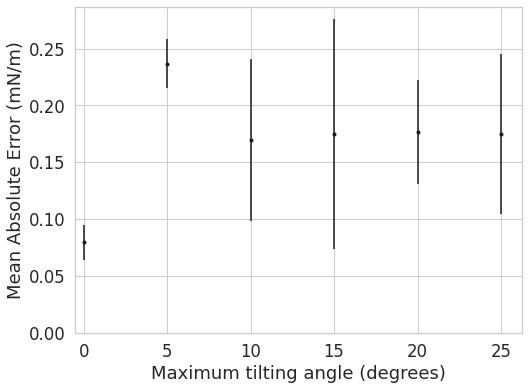

In [ ]:
from statistics import stdev
sns.set_theme(style='whitegrid', font_scale=1.5)
savefig=False

Mae_0=[0.11, 0.07, 0.08, 0.08, 0.07, 0.07]
Mae_5=[0.27, 0.23, 0.24, 0.22, 0.25, 0.21]
Mae_10=[0.11, 0.26, 0.15, 0.12, 0.12, 0.26]
Mae_15=[0.15, 0.09, 0.07, 0.21, 0.35, 0.18]
Mae_20=[0.19, 0.10, 0.20, 0.23, 0.19, 0.15]
Mae_25=[0.17, 0.12, 0.24, 0.28, 0.11, 0.13]

Mae_avg=[np.mean(Mae_0), np.mean(Mae_5), np.mean(Mae_10), np.mean(Mae_15), np.mean(Mae_20), np.mean(Mae_25)]

yerr=[stdev(Mae_0), stdev(Mae_5), stdev(Mae_10), stdev(Mae_15), stdev(Mae_20), stdev(Mae_25)]
angles=np.array([0, 5, 10, 15, 20, 25])

plt.figure(figsize=(8,6))
# plt.plot(angles, Mae_avg, 'ok')
plt.errorbar(angles, Mae_avg, yerr, fmt='.k')
# plt.vlines(angles, min_err, max_err, color='k')  # draw a vertical line
plt.xlabel('Maximum tilting angle (degrees)')
plt.ylabel('Mean Absolute Error (mN/m)')
plt.xlim(-0.5)
plt.ylim(0)
if savefig==True:
  plt.savefig(path+'MAE_Vs_ST_degree_of_tilt_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'MAE_Vs_ST_degree_of_tilt_png_'+date, dpi=300, format='png')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


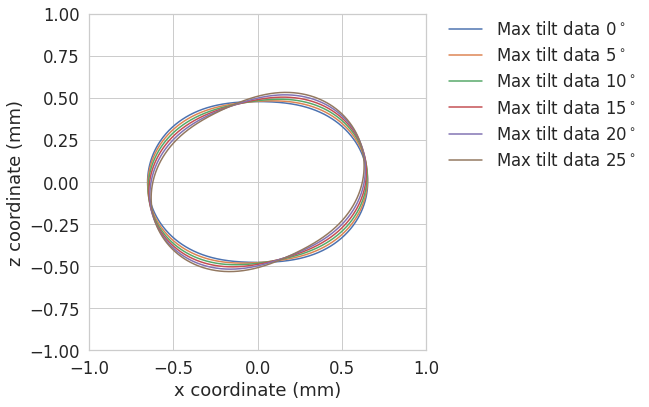

In [ ]:
dataset900=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
sampling=900
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')

sns.set_theme(style='whitegrid', font_scale=1.5)
savefig=True
angles=[0, 5, 10, 15, 20, 25]
degree2rad=np.pi/180

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
# plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
# plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
for i in range(len(angles)):
  angle=np.repeat(angles[i], len(dataset900))*degree2rad
  x, y=pol2cart_theta(dataset900.iloc[0, 0:sampling].values, dataset900.iloc[0, sampling:sampling*2].values)
  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[0, np.newaxis], x) - np.multiply(np.sin(angle)[0, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[0, np.newaxis], x) + np.multiply(np.cos(angle)[0, np.newaxis], y)
  plt.plot(rot_x, rot_y, label='Max tilt data %d$^\circ$' %angles[i])
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()
if savefig==True:
  plt.savefig(path+'tilted_pos_contours_svg'+date, dpi=300, format='svg')
  plt.savefig(path+'tilted_pos_contours_png'+date, dpi=300, format='png')



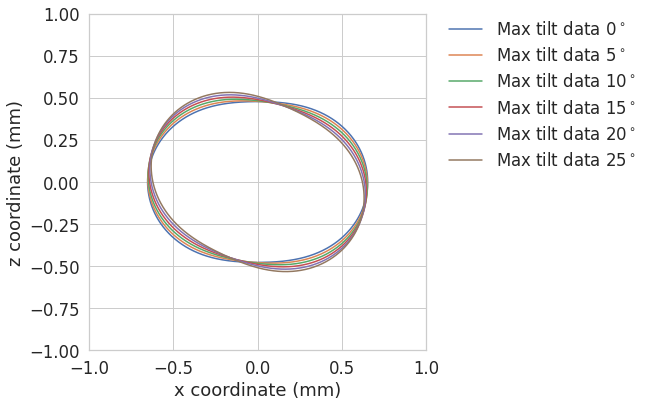

In [ ]:
savefig=True

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
# plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
# plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
for i in range(len(angles)):
  angle=np.repeat(-angles[i], len(dataset900))*degree2rad
  x, y=pol2cart_theta(dataset900.iloc[0, 0:sampling].values, dataset900.iloc[0, sampling:sampling*2].values)
  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[0, np.newaxis], x) - np.multiply(np.sin(angle)[0, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[0, np.newaxis], x) + np.multiply(np.cos(angle)[0, np.newaxis], y)
  plt.plot(rot_x, rot_y, label='Max tilt data %d$^\circ$' %angles[i])
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()
if savefig==True:
  plt.savefig(path+'tilted_neg_contours_svg'+date, dpi=300, format='svg')
  plt.savefig(path+'tilted_neg_contours_png'+date, dpi=300, format='png')

In [ ]:

min_val, max_val = -angles[i]*degree2rad, angles[i]*degree2rad
range_size = (max_val - min_val)  
# np.random.seed(1)
angle=np.repeat(45*degree2rad, num_sample) #np.random.rand(num_sample) * range_size + min_val

x, y=pol2cart_theta(dataset900.iloc[:, 0:sampling].values, dataset900.iloc[:, sampling:sampling*2].values)
rot_x = np.multiply(np.cos(angle)[:, np.newaxis], x) - np.multiply(np.sin(angle)[:, np.newaxis], y)
rot_y = np.multiply(np.sin(angle)[:, np.newaxis], x) + np.multiply(np.cos(angle)[:, np.newaxis], y)

# rot_rho, rot_phi = cart2pol(rot_x, rot_y)

i_max=find_nearest(angle, max(angle))[1]
i_min=find_nearest(angle, min(angle))[1]

plt.figure()
plt.plot(x[i_max], y[i_max])
plt.plot(rot_x[i_max], rot_y[i_max])
plt.plot(x[i_min], y[i_min])
plt.plot(rot_x[i_min], rot_y[i_min])
plt.plot(x[i_min], y[i_min])
plt.plot(rot_x[i_min], rot_y[i_min])
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
ax = plt.gca()
ax.set_aspect(1)
# ax.set_xlim([-0.65,0.65])
# ax.set_ylim([-0.65,0.65])

plt.figure()
plt.plot(x[i_max]-rot_x[i_max])
plt.plot(x[i_min]-rot_x[i_min])

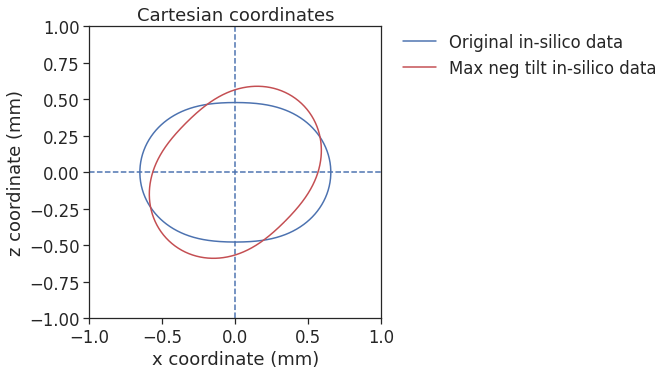

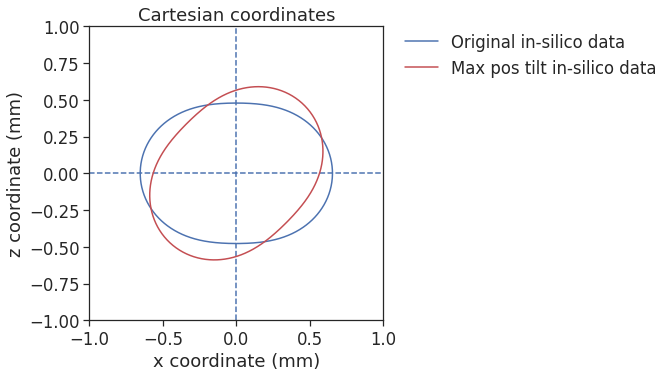

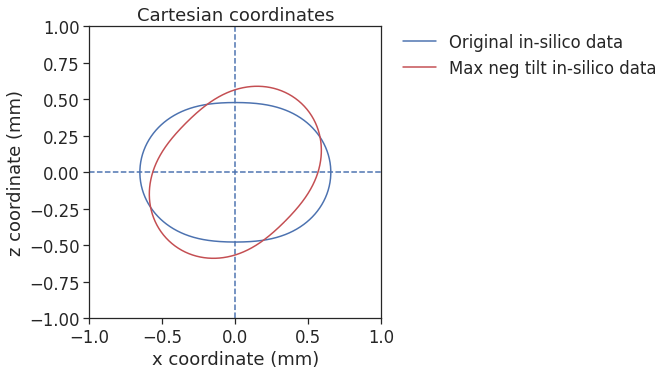

In [ ]:
i_max=find_nearest(angle, max(angle))[1]
i_min=find_nearest(angle, min(angle))[1]

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
plt.plot(x[i_max], y[i_max], 'b', label='Original in-silico data')
plt.plot(rot_x[i_max], rot_y[i_max], 'r', label='Max pos tilt in-silico data')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
plt.plot(x[i_min], y[i_min], 'b', label='Original in-silico data')
plt.plot(rot_x[i_min], rot_y[i_min], 'r', label='Max neg tilt in-silico data')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()

In [ ]:
# plt.figure(figsize=(8,6))
# for i in range(1,2): 
#   plt.plot(rot_x[i_max]-x[i_max], label='Difference of x coord')
#   plt.plot(rot_y[i_max]-y[i_max], label='Difference of y coord')
# # ax = plt.gca()
# # ax.set_aspect(1)
# # ax.set_xlim([-1.5,1.5])
# # ax.set_ylim([-1.5,1.5])
# plt.xlabel('x coordinate (mm)')
# plt.ylabel('z coordinate (mm)')
# plt.legend(frameon=False)

# plt.figure(figsize=(8,6))
# for i in range(1,2): 
#   plt.plot(rot_x[i_min]-x[i_min], label='Difference of x coord')
#   plt.plot(rot_y[i_min]-y[i_min], label='Difference of y coord')
# # ax = plt.gca()
# # ax.set_aspect(1)
# # ax.set_xlim([-1.5,1.5])
# # ax.set_ylim([-1.5,1.5])
# plt.xlabel('x coordinate (mm)')
# plt.ylabel('z coordinate (mm)')
# plt.legend(frameon=False)

### Saving

In [ ]:
#Save prediction outcome in a csv file
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20220405')

model_No=1

data_No=50547
ST_min=30
ST_max=72
vol_min=0.5
vol_max=2.5
Ps_min=1500
Ps_max=4000
error=0.08

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_MSE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))
!mkdir -p '/content/drive/My Drive/DropLev/for_draft/In_silico/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_'+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_'+filename, index=False)  #Saves the file

hist.to_csv(path+'history_'+filename)


In [ ]:
#Save training dataset

train_data.to_csv(path+'training_dataset_eq_rho_'+filename)

## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('All_surf_five_feutures_Huber_swish_trial_3.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 50)                15150     
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 153       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 4         
Total params: 15,307
Trainable params: 15,307
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.43203562],
       [-0.3725443 ],
       [ 0.15722759],
       [-0.407181  ],
       [-0.37564555],
       [-0.37614414],
       [-0.3925074 ],
       [-0.04143935],
       [ 0.6424061 ],
       [ 0.6858951 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')

#Save the k-th epoch (100 in this case)
#class CustomSaver(keras.callbacks.Callback):
#    filepath="/content/drive/My Drive/DropLev/MachineLearningModels/"
#    def on_epoch_end(self, epoch, logs={}):
#        if epoch == 100:  # or save after some epoch, each k-th epoch etc.
#           self.model.save(str(filepath+"SDS_70mNperm_trial1.h5"), monitor = "val_loss", verbose = 0,
#  save_best_only = False, save_weights_only = False, mode = "min", period = 1)

EPOCHS = 700

#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/saved-model-{epoch:02d}-{val_loss:.2f}.h5.h5"
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, 
#                                save_weights_only=False, mode='auto', period=1)
#callbacks_list = [checkpoint]

## create and use callback:
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.100EPOCHS.h5"
#saver = CustomSaver()
#history = model.fit(normed_train_data, train_labels, callbacks=[saver], epochs=10)

#Checkpoints. Save best fit
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.best.h5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint]

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list


....................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
15,7.163245,7.163245,130.577637,7.792389,7.792389,141.851059,15
16,7.162131,7.162131,130.552383,7.785986,7.785986,141.798523,16
17,7.154714,7.154715,130.544373,7.785559,7.785559,141.747849,17
18,7.148772,7.148772,130.395157,7.756837,7.756837,141.482620,18
19,7.155182,7.155182,130.323730,7.777982,7.777982,141.616928,19


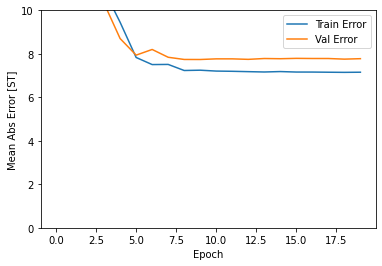

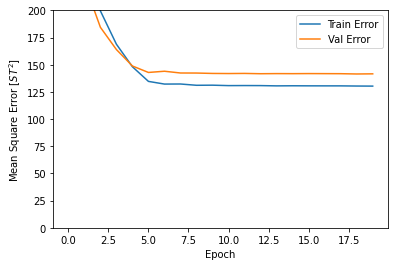

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))
# 
#keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error:  7.44 mN/m


### Make predictions

Finally, predict volume values using data in the testing set:

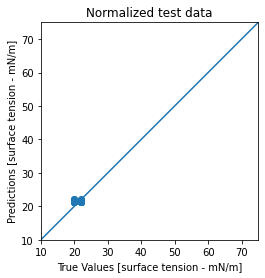

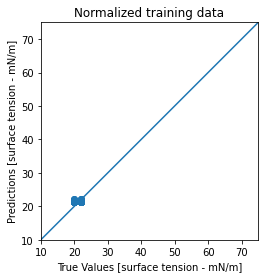

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


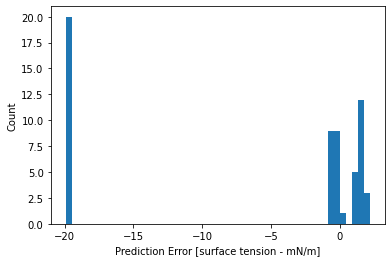

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
plt.show()

## Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
modelfilename=str('Model_data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_MSE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))
# filename='model_1_no_30_37_mN/m_20211130.csv'

# !mkdir -p '/content/drive/My Drive/DropLev/for_draft/In_silico/' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/for_draft/In_silico/'+modelfilename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_st_prediction_model directory
#!ls content/drive/My Drive/DropLev/MachineLearningModels

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls content/drive/My Drive/DropLev/MachineLearningModels/SDS_1.h5

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('content/drive/My Drive/DropLev/MachineLearningModels/'+filename) 

## Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/'+filename)

# Check its architecture
new_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                14120     
                                                                 
 dense_1 (Dense)             (None, 25)                1025      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 15,281
Trainable params: 15,281
Non-trainable params: 0
______________

For **HDF5** format

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('DropLev_st_prediction_model.h5')

# Show the model architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)

## Adding noise to the contour

In [ ]:
#Import data

dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
dataset.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST,AR,radius
50423,0.609568,0.609584,0.609610,0.609648,0.609696,0.609755,0.609824,0.609905,0.609996,0.610098,...,3.107102,3.114077,3.121051,3.128026,3.135,1.339101,2440.778163,46.934689,0.845590,0.720867
50424,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301,0.892451,0.686405
50425,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300,0.877662,0.787381
50426,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339,0.834428,0.588568
50427,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363,0.899226,0.692040


In [ ]:

#Choosing 175 points with constant phi

sampling=900
points=175
new_phi=np.linspace(-3.13, 3.13, points)

new_rho=[]

### Interpolate to find all the radius for specific theta
for k in range(len(dataset)):
  x, y = pol2cart_theta(dataset.iloc[k, 0:sampling].values, dataset.iloc[k, sampling:2*sampling].values)
  rho, phi=cart2pol(x, y)
  contour_interp=interp1d(phi, rho, kind='slinear')
  new_rho.append(contour_interp(new_phi))

theta = []
theta_array = []
features = pd.DataFrame()

rho_n=[]

for k in range(points):
  rho_n.append(str('row_%d' %k))

features[rho_n]=new_rho

# for k in range(points):
#   theta.append(str('theta_%d' %k))

# x, y = pol2cart(new_rho, new_phi)
# theta_array = azimuth(x, y)

# features[theta] = theta_array

features_DF=pd.concat([features, dataset.iloc[:, 2*sampling:]], axis=1)

AR=features_DF.pop('AR')
radius=features_DF.pop('radius')
vol=features_DF.pop('vol')
features_DF.tail()


dataset=features_DF.copy()

dataset.tail()





/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
50423,0.720853,0.720616,0.720093,0.719286,0.718199,0.716837,0.715208,0.713321,0.711185,0.708811,...,0.713322,0.715209,0.716837,0.718198,0.719285,0.720093,0.720617,0.720854,2440.778163,46.934689
50424,0.686396,0.686239,0.685892,0.685357,0.684636,0.683733,0.682653,0.681401,0.679984,0.678410,...,0.681402,0.682653,0.683733,0.684636,0.685357,0.685892,0.686240,0.686397,2409.976323,63.571301
50425,0.787369,0.787164,0.786711,0.786013,0.785072,0.783894,0.782484,0.780851,0.779002,0.776948,...,0.780851,0.782484,0.783893,0.785071,0.786012,0.786711,0.787165,0.787370,2246.471091,59.265300
50426,0.588555,0.588348,0.587890,0.587183,0.586232,0.585039,0.583613,0.581961,0.580090,0.578012,...,0.581961,0.583614,0.585039,0.586231,0.587183,0.587890,0.588348,0.588556,3058.148777,50.762339
50427,0.692031,0.691883,0.691555,0.691050,0.690369,0.689515,0.688495,0.687312,0.685974,0.684487,...,0.687313,0.688495,0.689515,0.690368,0.691049,0.691555,0.691883,0.692032,1656.011831,32.620363


In [ ]:
import random 
points=175
pxl1=0.83/217.5 #mm
phi=np.linspace(-3.13, 3.13, points)
# percent=0.5 #50%

random_noise=pxl1*np.random.uniform(-1, 1, size=[len(dataset), 175])
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) #
noisy_rho={}

for i in range(len(scale_list)):
  noisy_rho[i]=dataset.iloc[:, 0:175]+random_noise*scale_list[i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in double_scalars


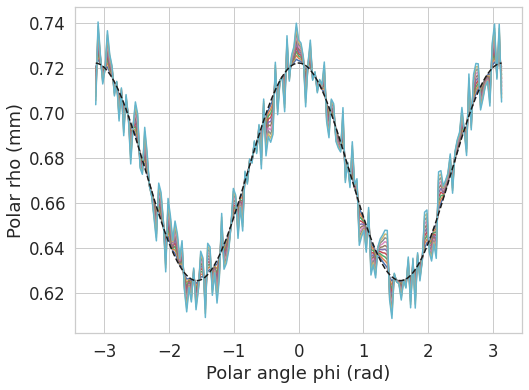

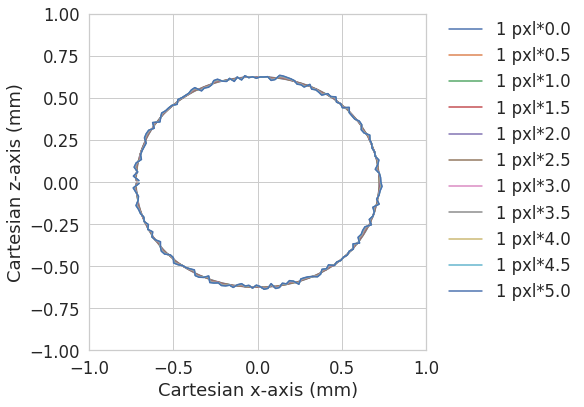

Droplet's characteristics: 1.37 μL, 2765.23 Pa, 70.89 mN/m


In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/'
savefig=False

x,y=pol2cart(dataset.iloc[1, 0:points].values, phi)
volume=calc_volume(x,y)
R_sph=calc_R_sph(volume)

plt.figure(figsize=(8,6))
for i in range(len(scale_list)-1):
  plt.plot(phi, noisy_rho[i+1].iloc[1, :], label='1xpl*%.1f' %scale_list[i+1])
plt.plot(phi, dataset.iloc[1, 0:points], 'k--', label='No noise')

plt.xlabel('Polar angle phi (rad)')
plt.ylabel('Polar rho (mm)')
if savefig==True:
  plt.savefig(str(path+'noisy_contours_polar_ %.2f_μL_%.2f_Pa_%.2f_mNm_svg' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='svg')
  plt.savefig(str(path+'noisy_contours_polar_ %.2f_μL_%.2f_Pa_%.2f_mNm_png' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='png')
# ax1.legend(frameon=False)

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  x, y = pol2cart(noisy_rho[i].iloc[1, :].values, phi)
  plt.plot(x, y, label='1 pxl*%.1f' %scale_list[i])
# x, y = pol2cart(dataset.iloc[1, 0:points].values, phi)
# plt.plot(x, y, 'k--', label='No noise')
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()


if savefig==True:
  plt.savefig(str(path+'noisy_contours_Cart_ %.2f μL_%.2f Pa_%.2f mNm_svg' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='svg')
  plt.savefig(str(path+'noisy_contours_Cart_ %.2f μL_%.2f Pa_%.2f mNm_png' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='png')
plt.show()

print('''Droplet's characteristics: %.2f μL, %.2f Pa, %.2f mN/m''' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176]))

In [ ]:
# #Remove features that are not used in the training

# vol=dataset.pop('vol')
# AR=dataset.pop('AR')
# radius=dataset.pop('radius')


In [ ]:
from numpy.random import seed

sseed=50
def build_model():
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data[0].keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  optimizer = tf.keras.optimizers.Adam() #learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  #model.compile(loss='mean_squared_error',
  #              optimizer=optimizer,
  #              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MAE_png', dpi=300, format='png')

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MSE_png', dpi=300, format='png')
  plt.show()



In [ ]:
#Min-Max transformation

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(train_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [ ]:
## Re-scale target feature
def rescaling(target):
  min=stats.loc['ST']['min']
  max=stats.loc['ST']['max']
  target=np.asarray(target)
  return (max-min)*(target)+min


In [ ]:
#Normalizing data
points=175

#Normed data with noise
# Normed_rho_with_noise={}
Normed_data={}

for i in range(len(scale_list)):
  Normed_data[i] = MinMaxTransformTrain(noisy_rho[i], points)
  # Normed_data_with_noise[i]=pd.concat([Normed_rho_with_noise, normed_data.iloc[:, 175:]], axis=1)


In [ ]:
#Inspect the data
stats = dataset.iloc[:, points:].describe()
stats = stats.transpose()


#Normalizing the rest of the data
normed_data_rest = min_max_norm(dataset.iloc[:, points:])
# normed_data['volume'] = normed_data_rest.vol


for i in range(len(scale_list)):
  # Normed_data_with_noise[i]['volume'] = normed_data_rest.vol
  Normed_data[i]['Ps'] = normed_data_rest.Ps
  Normed_data[i]['ST'] = normed_data_rest.ST


In [ ]:
from sklearn.utils import shuffle

normed_data={}

np.random.seed(1234)

for i in range(len(scale_list)):
  normed_data[i]=shuffle(Normed_data[i], random_state=0)
  normed_data[i].reset_index(drop=True, inplace=True)


In [ ]:
#Noisy data
#Split data into train and test
normed_train_data={}
normed_test_data={}
train_labels={}
test_labels={}


mae_all={}
rows_05_all={}
rows_1_all={}
rows_2_all={}



path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)


for i in range(len(scale_list)):
  np.random.seed(1234)
  normed_train_data[i] = normed_data[i].sample(frac=0.8,random_state=0)
  normed_test_data[i] = normed_data[i].drop(normed_train_data[i].index)
  train_labels[i] = normed_train_data[i].pop('ST')
  train_labels[i].reset_index(drop=True, inplace=True)
  test_labels[i] = normed_test_data[i].pop('ST')
  test_labels[i].reset_index(drop=True, inplace=True)


  for j in range(6):
    
    sseed=j

    model = build_model()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data[i], train_labels[i], epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    ## Re-scale target feature
    test_predictions = model.predict(normed_test_data[i]).flatten()
    train_predictions = model.predict(normed_train_data[i]).flatten()

    ST_real_test=rescaling(test_labels[i])
    ST_pred_test=rescaling(test_predictions)

    ST_real_train=rescaling(train_labels[i])
    ST_pred_train=rescaling(train_predictions)  

    error_test = ST_pred_test - ST_real_test
    error_test_test=np.asarray(error_test)

    rows_05=(error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)])
    rows_1=(error_test_test[(error_test_test >= -1) & (error_test_test <= 1)])
    rows_2=(error_test_test[(error_test_test >= -2) & (error_test_test <= 2)])

    rows_05_all[i,j]=len(rows_05)/len(error_test)

    rows_1_all[i,j]=len(rows_1)/len(error_test)

    rows_2_all[i,j]=len(rows_2)/len(error_test)

    mae_all[i,j]=(sum(abs(error_test_test))/len(error_test_test))

    hist.to_csv(path+'history_degree_noise_%.2f_rep_%d_MAE_%.2f_' %(scale_list[i], j, mae_all[i, j]) +date)

    noisy_training_outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])
    noisy_training_outcome_test.to_csv(path+'noisy_training_outcome_test_degree_%.2f_rep_%d_' %(scale_list[i], j) + date, index=False)  #Saves the file
    noisy_training_outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=[ 'Train_labels', 'Train_pred'])
    noisy_training_outcome_train.to_csv(path+'noisy_training_outcome_train_degree_%.2f_rep_%d_' %(scale_list[i], j) + date, index=False)  #Saves the file



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



........................................

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



...............................................
...........................................................
...........................................................................
....................................................
............................
..................................................................
......................................................................................
..........................................................
...............................................................
......................................................
.......................................................................................
......................................
...........................................................
.......................................
....................................................................
........................................................................................
................

### Figures

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

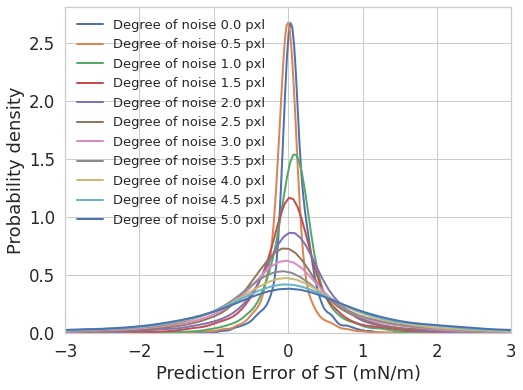

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')
thickness=2
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 
savefig=True

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  error_test_noise=[]
  for j in range(6):
    file=pd.read_csv(path+'noisy_training_outcome_test_degree_%.2f_rep_%d_' %(scale_list[i], j) + date)
    error_test_noise.append(file.Test_pred-file.Test_labels)
    average_error=[np.mean(k) for k in zip(*error_test_noise)]
  sns.distplot(average_error, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.1f pxl' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.xlim(-3, 3)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

In [ ]:

# # all_mae=np.insert(np.asarray([list(mae_noisy.items())])[0][:, 1], 0, mae)
# all_degrees=np.insert(scale_list, 0, 0)

# # date='20220406'
# savefig=True
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

# plt.figure(figsize=(8,6))
# plt.plot(all_degrees, mae_all, '-o')
# plt.xlabel('Degree of noise (pixels)')
# plt.ylabel('Mean absolute error (mN/m)')
# if savefig==True:
#   plt.savefig(path+'MAE_Vs_degree_of_noise_svg_'+date, dpi=300, format='svg')
#   plt.savefig(path+'MAE_Vs_degree_of_noise_png_'+date, dpi=300, format='png')

# print(all_mae)


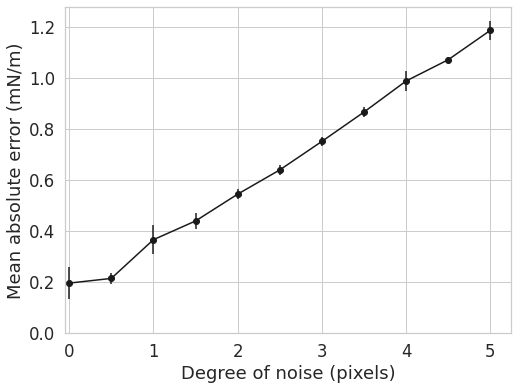

In [ ]:
from statistics import stdev

mae_0=[0.08, 0.24, 0.24, 0.21, 0.18, 0.23]
mae_05=[0.23, 0.20, 0.24, 0.20, 0.23, 0.19]
mae_1=[0.41, 0.32, 0.46, 0.36, 0.34, 0.31]
mae_15=[0.45, 0.49, 0.43, 0.40, 0.43, 0.44]
mae_2=[0.53, 0.53, 0.57, 0.54, 0.57, 0.53]
mae_25=[0.65, 0.63, 0.67, 0.63, 0.62, 0.64]

mae_3=[0.78, 0.74, 0.75, 0.73, 0.76, 0.75]
mae_35=[0.86, 0.88, 0.88, 0.85, 0.84, 0.89]
mae_4=[0.97, 1.00, 0.97, 1.06, 0.95, 0.98]
mae_45=[1.08, 1.08, 1.08, 1.06, 1.07, 1.06]
mae_5=[1.18, 1.16, 1.26, 1.17, 1.18, 1.17]

all_mae=np.array([np.mean(mae_0), np.mean(mae_05), np.mean(mae_1), np.mean(mae_15), np.mean(mae_2), np.mean(mae_25), np.mean(mae_3), np.mean(mae_35), np.mean(mae_4), np.mean(mae_45), np.mean(mae_5)])
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 

 
yerr=np.array([stdev(mae_0), stdev(mae_05), stdev(mae_1), stdev(mae_15), stdev(mae_2), stdev(mae_25), stdev(mae_3), stdev(mae_35), stdev(mae_4), stdev(mae_45), stdev(mae_5)])

savefig=True
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

plt.figure(figsize=(8,6))
plt.plot(scale_list, all_mae, '-ok')
plt.errorbar(scale_list, all_mae, yerr, fmt='.k')
plt.xlabel('Degree of noise (pixels)')
plt.ylabel('Mean absolute error (mN/m)')
plt.xlim(-0.05)
plt.ylim(0)
if savefig==True:
  plt.savefig(path+'MAE_Vs_degree_of_noise_with_errorbars_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'MAE_Vs_degree_of_noise_with_errorbars_png_'+date, dpi=300, format='png')


In [ ]:
files=glob.glob(path+"/*")

for i in range(len(files)):
  if files[i].endswith('.csv'):
    
    for j in range(len(scale_list)):
      print(files[j])

In [ ]:
import glob

#Error distribution
thickness=3

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'

files=glob.glob(path+"/*")

for i in range(len(files)):
  if files[i].endswith('.csv'):
    j=files[i]
    for j in range(len(scale_list)):
      if j.startswith('noisy_training_outcome_degree_%.2f' %scale_list[j]):
        dw

plt.figure(figsize=(8,6))
sns.distplot(error_test_test, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise 0')
for i in range(len(scale_list)):
  sns.distplot(error_test_noisy[i], hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.2f' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

In [ ]:
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
# date='20211209'
# mae=0.34
# mae_noisy=np.array([0.52, 0.54, 0.66, 0.65, 0.70, 0.81, 0.93, 0.96, 1.07, 1.22])

# hist_noisy={}

# scale_list=np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
# for i in range(len(scale_list)):
#   hist_noisy[i]=pd.read_csv(path+'history_degree_noise_%.2f_MAE_%.2f_' %(scale_list[i], mae_noisy[i]) +date)


# hist=pd.read_csv(path+'history_no_noise_MAE_%.2f_' %mae +date)


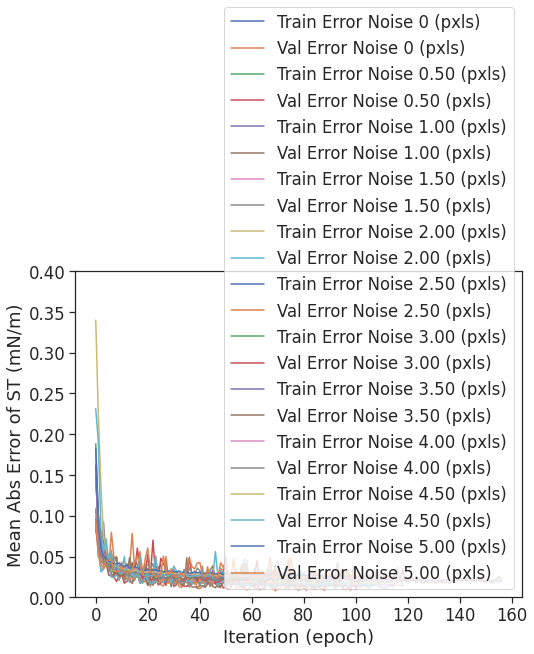

In [ ]:
#Training outcome MAE Vs epochs

sns.set_theme(style='ticks', font_scale=1.5) 
savefig=True
plt.figure(figsize=(8,6))
plt.xlabel('Iteration (epoch)')
plt.ylabel('Mean Abs Error of ST (mN/m)')
plt.ylim([0,0.4])
plt.plot(hist['epoch'], hist['mean_absolute_error'], 
          label='Train Error Noise 0 (pxls)')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
          label = 'Val Error Noise 0 (pxls)')
for i in range(len(scale_list)):
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['mean_absolute_error'], 
           label='Train Error Noise %.2f (pxls)' %scale_list[i])
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['val_mean_absolute_error'],
           label = 'Val Error Noise %.2f (pxls)' %scale_list[i])
plt.legend(fontsize = 5)
if savefig==True:
  path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
  plt.savefig(path+'MAE_Vs_epoch_noise_png_'+date, dpi=300, format='png')
  plt.savefig(path+'MAE_Vs_epoch_noise_svg_'+date, dpi=300, format='svg')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

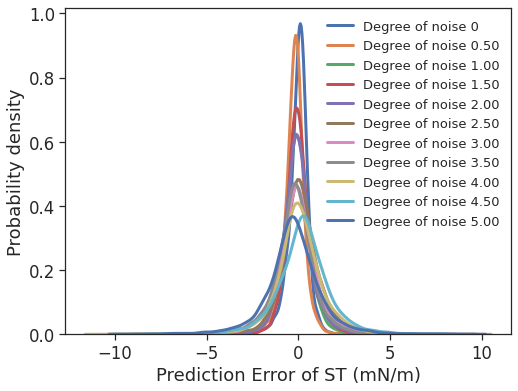

In [ ]:
#Error distribution
thickness=3

plt.figure(figsize=(8,6))
sns.distplot(error_test_test, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise 0')
for i in range(len(scale_list)):
  sns.distplot(error_test_noisy[i], hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.2f' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


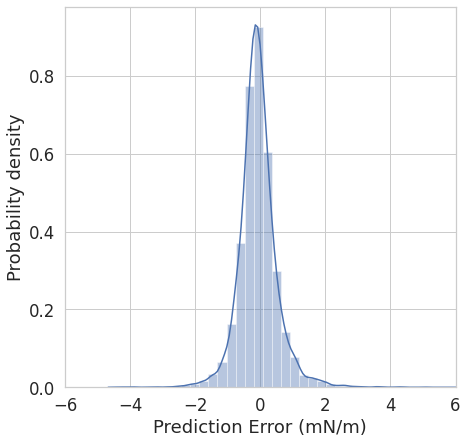

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


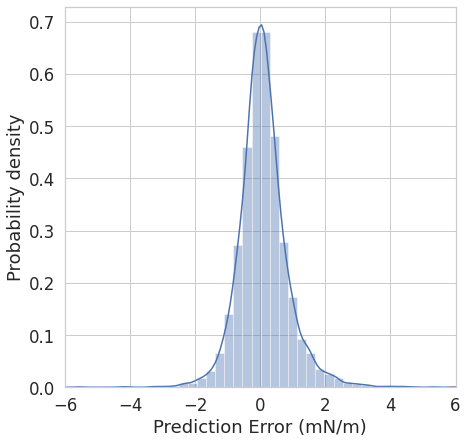

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


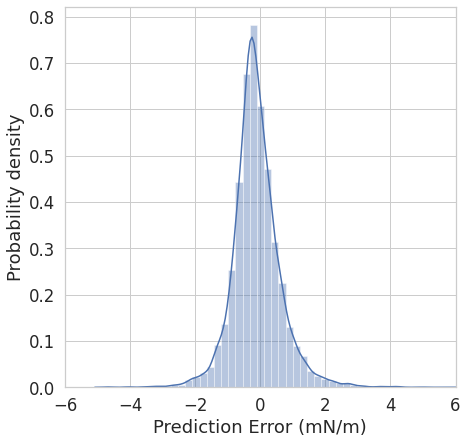

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


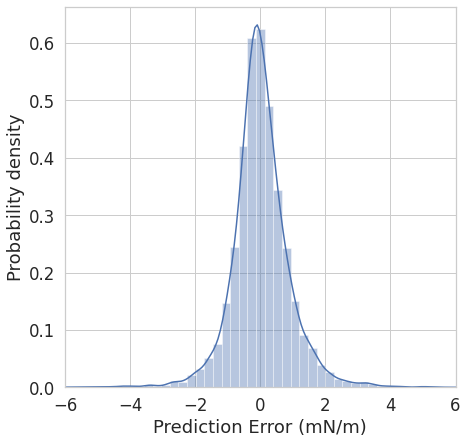

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


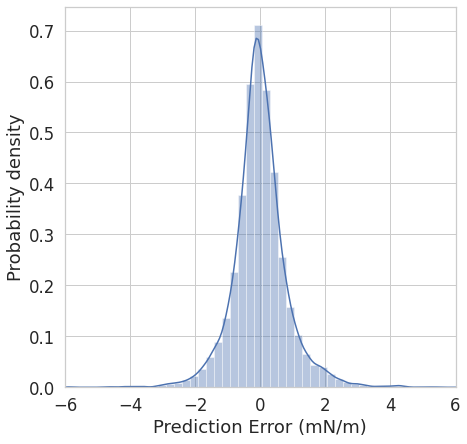

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


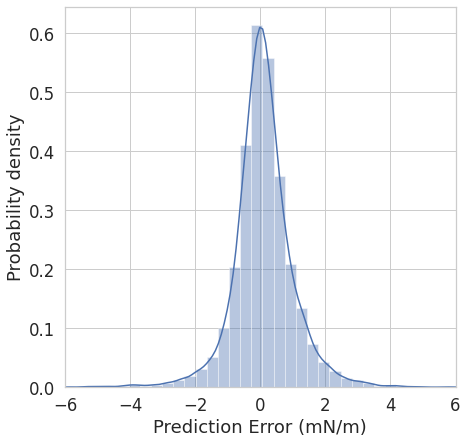

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


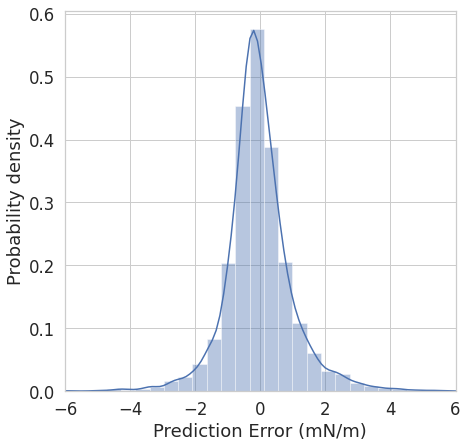

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


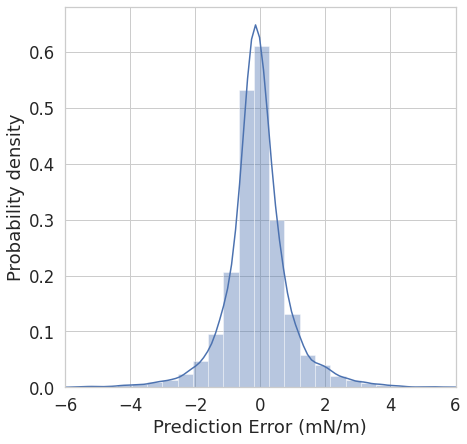

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


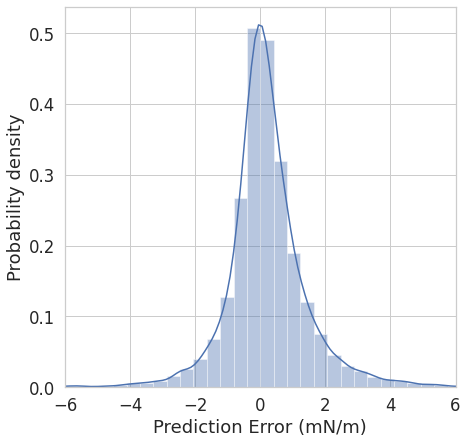

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


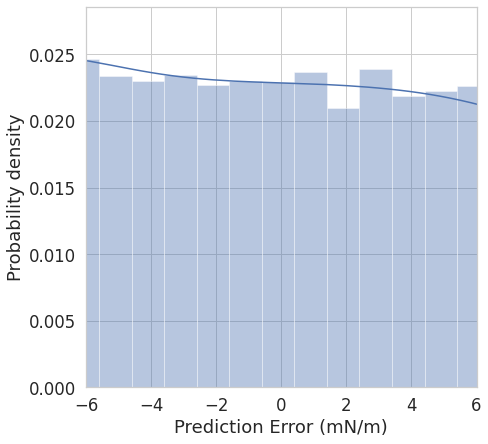

In [ ]:
# noise_test_predictions={}
# noise_train_predictions={}
# noise_error_test={}
# noise_error_train={}

# sns.set_theme(style='whitegrid', font_scale=1.5)

# for i in range(len(scale_list)):
#   noise_test_predictions[i] = model_noisy[i].predict(normed_noisy_test_data[i]).flatten()
#   noise_train_predictions[i] = model_noisy[i].predict(normed_noisy_train_data[i]).flatten()
#   noise_error_test[i] = noise_test_predictions[i] - test_labels_noise[i]
#   noise_error_train[i] = noise_train_predictions[i] - train_labels_noise[i]

#   plt.figure(figsize=(7,7))
#   sns.histplot(noise_error_test[i], bins = 50, kde=True, stat="density")
#   plt.xlabel("Prediction Error (mN/m)")
#   _ = plt.ylabel("Probability density")
#   plt.xlim(-6, 6)
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/error_distr_with_noise_%.1f' %scale_list[i], dpi=300, format='svg')
#   plt.show()


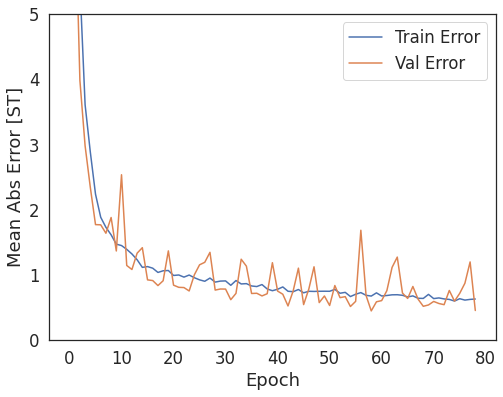

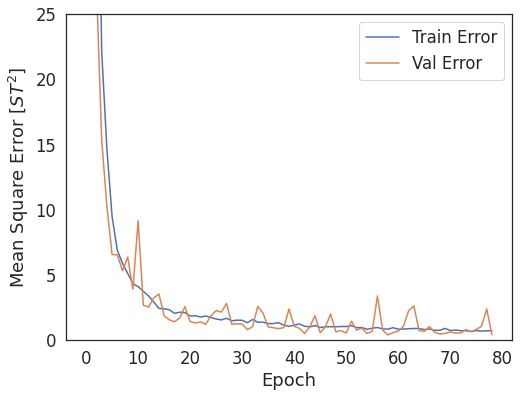

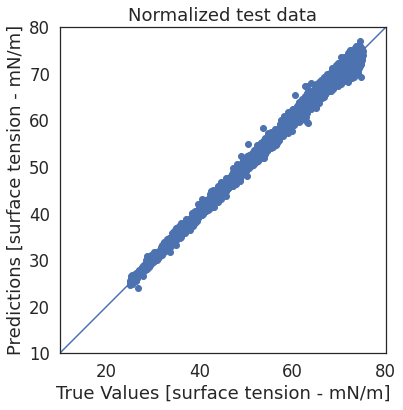

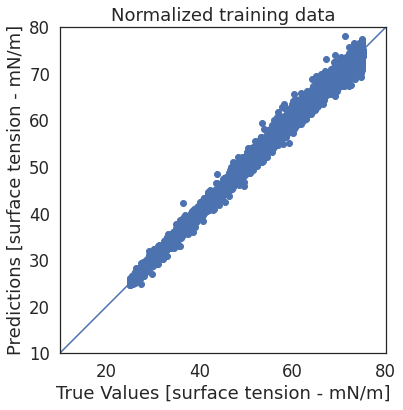

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


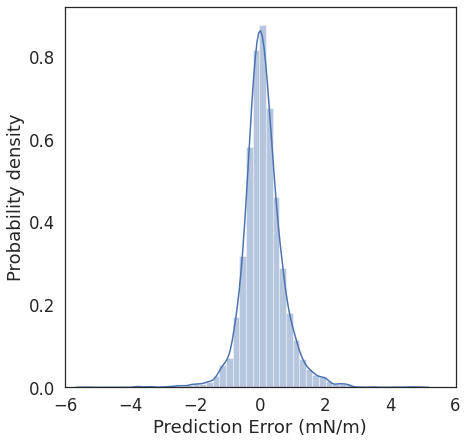

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


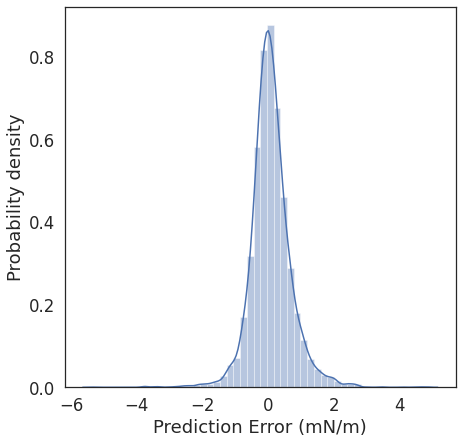

Text(0.5, 0, 'Surface tension (mN/m)')

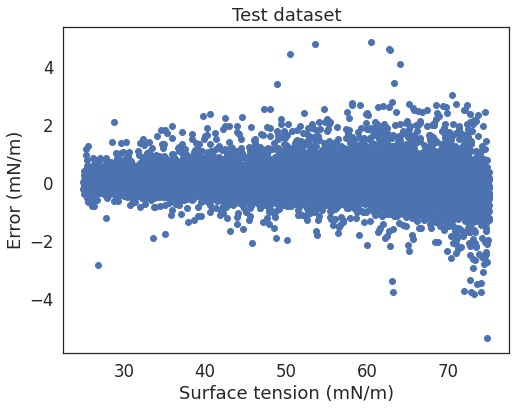

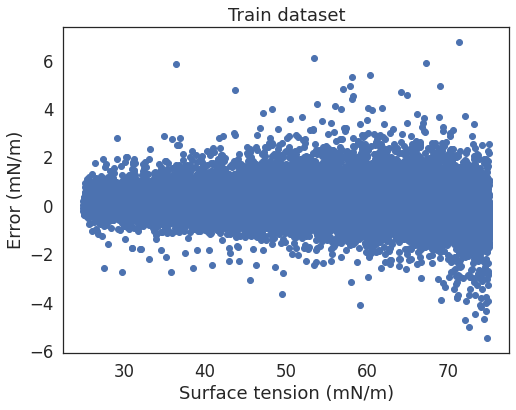

In [ ]:
# # Data without noise
# # Histrory
# plot_history(history)

# # Make predictions
# test_predictions = model.predict(normed_test_data).flatten()

# plt.figure(figsize=(8,6))
# plt.scatter(test_labels, test_predictions)
# plt.title('Normalized test data')
# plt.xlabel('True Values [surface tension - mN/m]')
# plt.ylabel('Predictions [surface tension - mN/m]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# # plt.savefig('Test_data_training', dpi=300, format='pdf')
# plt.show()

# train_predictions = model.predict(normed_train_data).flatten()

# plt.figure(figsize=(8,6))
# plt.scatter(train_labels, train_predictions)
# plt.title('Normalized training data')
# plt.xlabel('True Values [surface tension - mN/m]')
# plt.ylabel('Predictions [surface tension - mN/m]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# plt.show()


# #Error distribution

# error_test = test_predictions - test_labels

# plt.figure(figsize=(7,7))
# sns.histplot(error_test, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error (mN/m)")
# _ = plt.ylabel("Probability density")
# plt.xlim(-6, 6)
# # plt.savefig('error', dpi=300, format='pdf')
# plt.show()

# plt.figure(figsize=(7,7))
# sns.histplot(error_test, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error (mN/m)")
# _ = plt.ylabel("Probability density")
# plt.show()
# error_test = test_predictions - test_labels
# error_train = train_predictions - train_labels

# plt.figure(figsize=(8,6))
# plt.title('Test dataset')
# plt.plot(test_labels, error_test, 'o')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')

# plt.figure(figsize=(8,6))
# plt.title('Train dataset')
# plt.plot(train_labels, error_train, 'o')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')


In [ ]:
# #Save prediction outcome in a csv file
# error_test = test_predictions - test_labels
# error_train = train_predictions - train_labels
# outcome_train=pd.DataFrame(data=np.array([train_labels.values, train_predictions]).T, columns=['Train_labels', 'Train_pred'])
# outcome_test=pd.DataFrame(data=np.array([test_labels.values, test_predictions]).T, columns=[ 'Test_labels', 'Test_pred'])

# date=str('20211019')

# model_No=3

# data_No=46685
# ST_min=25
# ST_max=75
# vol_min=0.5
# vol_max=2.5
# Ps_min=2000
# Ps_max=4000


# filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, date))
# !mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
# outcome_train.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'train_out_'+filename, index=False)  #Saves the file
# outcome_test.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'test_out_'+filename, index=False)  #Saves the file

# hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_'+filename)


## Testing new data

In [ ]:
def prep_input(input, sampling=300):
  AR=[]
  width=[]
  # plt.figure()
  for j in range(len(input)):
    x,y=pol2cart_theta(np.asarray(input.iloc[j, 0:sampling]), np.asarray(input.iloc[j, sampling:2*sampling]))
    AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))
    width.append(max(x)-min(x))

  AR=np.asarray(AR)
  width=np.asarray(width)
  input['AR']=AR

  wavelength_lim = 343 / 40 # [mm] 
  radius=width/2

  input['radius']=radius


  pre_rslt_dataset= input[input['radius'] < wavelength_lim*0.1]
  pre_rslt_dataset.reset_index(drop=True, inplace=True)

  # Capillary length check
  ST_c=np.linspace(25, 74, len(pre_rslt_dataset))
  lambda_c=np.sqrt(ST_c/9.81)
  volume_c=(4/3)*np.pi*(lambda_c/2)**3

  rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['vol'] <= volume_c*0.7]
  rslt_dataset.reset_index(drop=True, inplace=True)

  #Aspect ratio
  Ar_limit=0.66

  final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]
  final_dataset.reset_index(drop=True, inplace=True)

  dataset=final_dataset.copy()

  dataset.pop("AR")
  dataset.pop('radius')
  dataset.pop('vol')

  # n=250
  # for i in range(0, n, 2):
  #   dataset.pop('theta_%d' %i)

  # for i in range(0,n, 2):
  #   dataset.pop('rho_%d' %i)

  rand_cont=np.linspace(0, len(dataset)-1, 10).astype(int)

  plt.figure(figsize=(8,6))
  plt.title('Cartesian coordinates')
  for i in rand_cont:
    x, y=pol2cart_theta(dataset.iloc[i, 0:sampling].values, dataset.iloc[i, sampling:2*sampling].values)
    plt.plot(x, y, '-o')
  ax = plt.gca()
  ax.set_aspect(1)
  ax.set_xlim([-1.5,1.5])
  ax.set_ylim([-1.5,1.5])
  plt.xlabel('x coordinate (mm)')
  plt.ylabel('z coordinate (mm)')

  return dataset





In [ ]:
#Min-Max transformation

def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, points:2*points].values))
    min_rho.append(min(train_dataset.iloc[i, points:2*points].values))
    max_theta.append(max(train_dataset.iloc[i, 0:points].values))
    min_theta.append(min(train_dataset.iloc[i, 0:points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_theta, df_rho], axis=1)

  return new_df


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [ ]:
def cont_learn(normed_data, model, frac=0.5,random_state=0):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')
  
  if frac>0:
    #Split data into train and test
    normed_train_data = normed_data.sample(frac=frac,random_state=random_state)
    normed_test_data = normed_data.drop(normed_train_data.index)

    # Split features from labels
    train_labels = normed_train_data.pop('ST')
    test_labels = normed_test_data.pop('ST')


    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
    
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    test_predictions = model.predict(normed_test_data).flatten()

  elif frac==0:
    normed_test_data=normed_data
    test_labels = normed_data.pop('ST')
    test_predictions = model.predict(normed_test_data).flatten()
    mae=model.evaluate(normed_data, test_labels, verbose=0)
    history=None
  return test_predictions, test_labels, mae, history


In [ ]:
def predict(normed_data, model):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')

  normed_test_data=normed_data.copy()
  test_labels = normed_test_data.pop('ST')
  test_predictions = model.predict(normed_test_data).flatten()
  loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
  history=None
  return test_predictions, test_labels, mae, history

In [ ]:

def plot_history(history, savemode=False, path=None, filenameMAE=None, filenameMSE=None):

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')
  plt.show()

In [ ]:
def gen_data(num_sample,sampling, savefig=False):

    np.random.seed(241)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(2.5-0.5)+0.5 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/343  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=343 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(4500-1300)+1300  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*2*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(74-25)+25
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)
    sns.set_theme(style='ticks', font_scale=1.5)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure(figsize=(8,6))
    sns.histplot(ST_range, kde=False, stat="density")
    plt.xlabel('Surface tension (mN/m)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_png', dpi=300, format='png')

    if type(vol_drop) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(vol_drop, kde=False, stat="density")
      plt.xlabel('Volume (μL)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_png', dpi=300, format='png')

    if type(Ps) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(Ps/1000, kde=False, stat="density")
      plt.xlabel('Acoustic pressure (kPa)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_png', dpi=300, format='png')

    sns.set_theme(style='whitegrid', font_scale=1.5)

    fig3 = plt.figure(figsize=(8,6))
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[0:sampling], j[sampling:2*sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_png', dpi=300, format='png')
    plt.show()


    return dataset



Standardize based on data of saved model

In [ ]:

path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/')

csvfilename='training_dataset_eq_rho_data_50547_ST_30.00_72.00_vol_0.50_2.50_Ps_1500_4000_model_2_MSE_0.34_20220208.csv'
# csvfilename='dataset_20220114_Model_2_ST_corr_080.csv'
# training_dataset_eq_rho
train_dataset=pd.read_csv(path+csvfilename)
train_dataset.pop('Unnamed: 0')
train_dataset.tail()

points=175

stats = train_dataset.iloc[:, 2*points:].describe()
# stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Ps,40503.0,2600.870133,686.579093,1500.007009,2007.876453,2550.435854,3150.125392,3999.969054
ST,40503.0,52.562827,11.788168,30.000302,42.771896,53.211170,62.760146,71.999490


### Import data

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_dataset_after_conditions.csv')
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [ ]:
#Remove 10% of the data within a specific ST range

target=len(dataset)*0.1

ST_lim1=37
ST_lim2=30

trial=dataset.copy()

trial.drop(trial[(trial['ST'] > ST_lim1)].index, inplace=True)
trial.drop(trial[(trial['ST'] < ST_lim2)].index, inplace=True)
print((len(dataset)-len(trial))*100/len(dataset))

89.91346442188237 4668.6


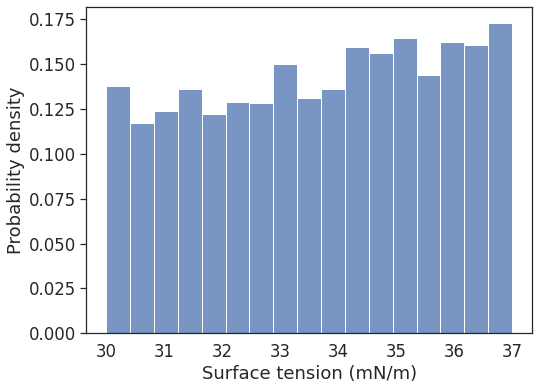

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(trial.ST, kde=False, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)

In [ ]:
dataset=trial.copy()
dataset.reset_index(drop=True, inplace=True)
dataset

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
0,0.018390,0.070453,0.241554,0.367267,0.472430,0.495262,0.540086,0.563635,0.592978,0.624496,0.631869,0.735346,0.761736,0.767978,0.801781,0.819314,0.845602,0.904731,0.945489,0.953636,0.987499,1.007197,1.074737,1.081028,1.087973,1.134097,1.166377,1.214199,1.259194,1.316490,1.326178,1.397697,1.415622,1.419542,1.505420,1.564812,1.643510,1.745301,1.752077,1.796733,...,0.709584,0.704998,0.704877,0.702198,0.698548,0.693512,0.690734,0.686218,0.676664,0.667193,0.665822,0.663568,0.662954,0.658536,0.655766,0.645613,0.639703,0.637653,0.636169,0.634261,0.625925,0.621900,0.611025,0.607310,0.601198,0.597725,0.584446,0.576343,0.575958,0.575217,0.573641,0.565261,0.560752,0.560434,0.559544,1.294405,2619.206780,33.413217,0.761708,0.734393
1,0.022041,0.075593,0.087488,0.101087,0.135662,0.186399,0.194859,0.258761,0.350516,0.411052,0.461075,0.464948,0.501280,0.518807,0.523795,0.553567,0.564530,0.572439,0.585171,0.592180,0.723248,0.755960,0.778340,0.839115,0.862264,0.949038,0.986992,1.000163,1.005385,1.038040,1.073359,1.105727,1.106948,1.134582,1.149566,1.207702,1.283804,1.378974,1.384091,1.389385,...,0.618613,0.618080,0.611691,0.593697,0.581008,0.574670,0.556407,0.555398,0.545777,0.532223,0.512660,0.509805,0.502978,0.498563,0.497433,0.497299,0.495085,0.489008,0.488830,0.484279,0.483040,0.480631,0.471141,0.464666,0.463063,0.462250,0.459243,0.447125,0.442143,0.440338,0.439257,0.438004,0.436249,0.435486,0.434134,0.787534,3539.019376,34.129512,0.675805,0.642127
2,0.056031,0.058364,0.102776,0.103351,0.105074,0.124741,0.145404,0.236549,0.239968,0.253712,0.373479,0.409880,0.428987,0.461754,0.512765,0.590793,0.593071,0.612229,0.671750,0.693052,0.701034,0.709992,0.758373,0.796262,0.871989,0.877338,0.899462,0.933515,0.967438,0.973334,1.033236,1.043266,1.089315,1.098893,1.175246,1.237283,1.245626,1.249970,1.273316,1.308882,...,0.827331,0.827318,0.819351,0.811820,0.798607,0.784573,0.768828,0.762729,0.761458,0.756558,0.745859,0.743532,0.735200,0.719364,0.714380,0.689779,0.670412,0.667523,0.665143,0.664702,0.657924,0.653882,0.652574,0.652473,0.646093,0.645676,0.639607,0.637324,0.637215,0.636725,0.627611,0.626222,0.624250,0.624067,0.624013,1.908522,2592.584982,36.567592,0.740948,0.842113
3,0.015517,0.015526,0.030288,0.056381,0.112602,0.117286,0.123093,0.125995,0.128862,0.279401,0.279623,0.295042,0.329923,0.345317,0.384359,0.418488,0.423851,0.460199,0.464100,0.539094,0.553190,0.562490,0.565536,0.567737,0.576705,0.649993,0.652552,0.775830,0.777597,0.815928,0.866615,0.887305,0.935501,0.965118,1.025576,1.060370,1.174066,1.210224,1.213093,1.272522,...,0.767560,0.767089,0.763333,0.762983,0.748392,0.742645,0.734065,0.731228,0.727338,0.724405,0.714375,0.703899,0.682771,0.678574,0.672786,0.669962,0.665786,0.654057,0.653062,0.644660,0.640075,0.638566,0.636389,0.633082,0.632955,0.628805,0.628303,0.625065,0.621936,0.621850,0.613828,0.600310,0.595441,0.594926,0.592504,1.615522,2654.723492,35.503575,0.744462,0.794970
4,0.107242,0.108267,0.122372,0.131830,0.144073,0.145474,0.182008,0.186700,0.193191,0.237380,0.265815,0.285088,0.306581,0.333894,0.352027,0.379464,0.428982,0.488718,0.490272,0.493671,0.504330,0.527771,0.547422,0.555722,0.708815,0.714358,0.752408,0.786742,0.809719,0.815404,0.829600,0.896956,0.957343,0.994505,1.025948,1.057526,1.074099,1.100145,1.183607,1.202590,...,0.556463,0.555411,0.553824,0.549159,0.547506,0.546925,0.54581

### Generate new data

(1000, 353)
25.058624362886803
73.99014049139967


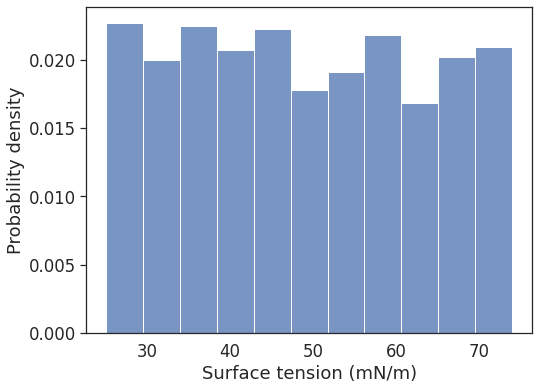

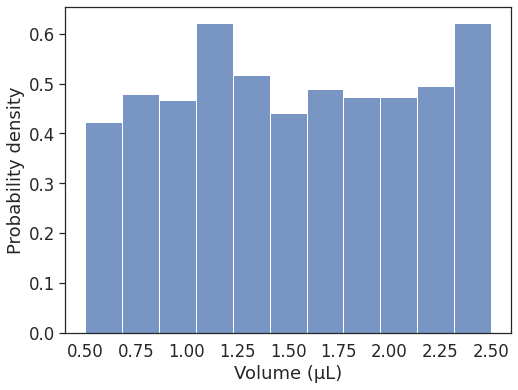

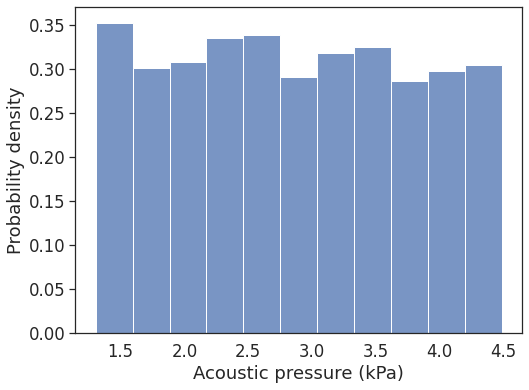

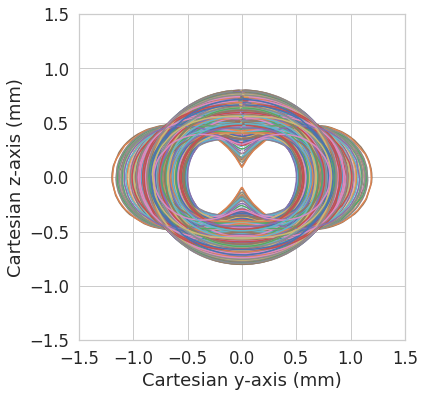

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_137,theta_138,theta_139,theta_140,theta_141,theta_142,theta_143,theta_144,theta_145,theta_146,theta_147,theta_148,theta_149,theta_150,theta_151,theta_152,theta_153,theta_154,theta_155,theta_156,theta_157,theta_158,theta_159,theta_160,theta_161,theta_162,theta_163,theta_164,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
628,0.478424,0.479581,0.483457,0.483519,0.486505,0.488019,0.488658,0.489783,0.490534,0.492510,0.495249,0.497421,0.498913,0.502125,0.502571,0.508774,0.509107,0.510715,0.515234,0.515956,0.516956,0.520141,0.525795,0.526666,0.527983,0.530406,0.536592,0.537514,0.546629,0.546929,0.551474,0.552408,0.557218,0.563481,0.564089,0.564204,0.564644,0.565978,0.566060,0.567170,...,4.702407,4.745605,4.750018,4.794586,4.823371,4.888271,4.926502,5.038509,5.080220,5.091677,5.143042,5.251866,5.321899,5.377489,5.477971,5.583178,5.595632,5.611238,5.619246,5.639345,5.684323,5.708351,5.728506,5.752096,5.779908,5.786249,5.861039,5.889808,5.897119,6.048291,6.051122,6.086310,6.173605,6.176350,6.186060,6.188811,6.243557,6.281286,3630.144879,70.112104
629,0.453835,0.454440,0.455542,0.456081,0.456752,0.457554,0.460435,0.462871,0.463370,0.466786,0.467436,0.468234,0.468498,0.472576,0.474077,0.483497,0.491351,0.504354,0.504955,0.507040,0.522406,0.522647,0.529374,0.544269,0.549723,0.552675,0.558970,0.561910,0.570958,0.580720,0.584440,0.585410,0.593362,0.610494,0.623730,0.625076,0.631397,0.632259,0.632773,0.636611,...,4.907468,5.087470,5.117360,5.125218,5.190198,5.282731,5.285191,5.336735,5.344362,5.441120,5.442579,5.447145,5.483406,5.494528,5.499535,5.499653,5.501462,5.578543,5.583629,5.614221,5.704182,5.722172,5.805434,5.808448,5.831356,5.857760,5.929928,6.008111,6.034977,6.107428,6.129149,6.142656,6.159203,6.171222,6.177156,6.187738,6.214181,6.246718,4014.845562,50.548503
630,0.616025,0.616834,0.619860,0.623656,0.624639,0.626451,0.628898,0.628904,0.629229,0.631820,0.638290,0.639133,0.648704,0.656728,0.664325,0.669337,0.672792,0.674223,0.685476,0.685796,0.687399,0.691090,0.691192,0.694074,0.694444,0.695090,0.698633,0.699465,0.700513,0.703143,0.704093,0.705245,0.705735,0.706214,0.707491,0.708456,0.708874,0.709692,0.709803,0.710912,...,4.786725,4.800324,4.813133,4.832934,4.836747,4.894180,4.922842,5.013575,5.022927,5.033150,5.057875,5.067314,5.070738,5.108680,5.128832,5.168367,5.301349,5.329527,5.390508,5.421100,5.431041,5.470697,5.497536,5.609894,5.648993,5.668718,5.690391,5.813317,5.853274,5.949468,6.044156,6.077207,6.092502,6.187740,6.250905,6.264178,6.268223,6.269465,2837.826180,73.096014
631,0.560394,0.562716,0.563205,0.565407,0.567416,0.569684,0.578260,0.579603,0.587200,0.596067,0.598423,0.616595,0.623059,0.639380,0.647922,0.684171,0.687912,0.703439,0.707982,0.745278,0.762348,0.784455,0.784471,0.790101,0.795261,0.795953,0.802220,0.808979,0.812903,0.813403,0.815603,0.817594,0.821754,0.823747,0.824245,0.824325,0.824269,0.824269,0.824204,0.820968,...,4.960868,5.032999,5.054594,5.062073,5.086827,5.099633,5.228867,5.245898,5.284889,5.360816,5.363696,5.402288,5.477814,5.506059,5.548634,5.553889,5.705856,5.719949,5.730442,5.736970,5.743353,5.751807,5.823244,5.875199,5.876351,5.923463,5.975887,6.095685,6.099406,6.102251,6.105383,6.160195,6.163228,6.207100,6.210969,6.225618,6.267184,6.273983,4165.495650,69.473999
632,0.493084,0.493125,0.494770,0.495037,0.495075,0.495582,0.495669,0.495954,0.502668,0.504911,0.510135,0.514637,0.516486,0.517782,0.520844,0.527372,0.529548,0.536006,0.544315,0.546661,0.548364,0.551091,0.553310,0.553449,0.561283,0.562188,0.582843,0.584202,0.587144,0.588367,0.593978,0.594264,0.617540,0.617575,0.618657,0.624317,0.625015,0.625588,0.629781,0.630931,...,4.981662,4.992300,5.042389,5.098143,5.17895

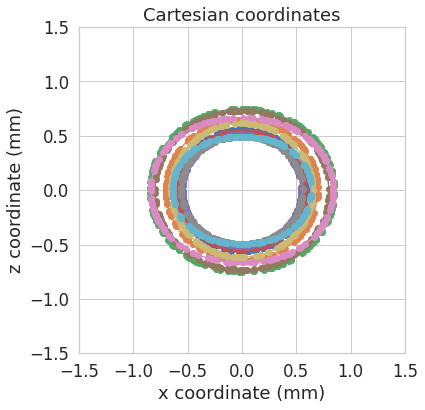

In [ ]:

num_sample=1000  # number of different ST values
sampling=175 # number of coordiante point describing the contour


new_data=gen_data(num_sample, sampling)


column_names=[]
for i in range(sampling):
  column_names.append('rho_%d' %i)
for i in range(sampling):
  column_names.append('theta_%d' %i)
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


new_dataset = pd.DataFrame(new_data, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)

clean_dataset=prep_input(new_dataset, sampling=sampling)

clean_dataset.tail()

In [ ]:
## Normalize based on training dataset

unseen_normed_rho_theta=MinMaxTransformTest(clean_dataset, train_dataset, points)

unseen_normed_data_rest = min_max_norm(clean_dataset.iloc[:, points*2:])

unseen_normed_data = unseen_normed_rho_theta.copy()
unseen_normed_data['Ps'] = unseen_normed_data_rest.Ps
unseen_normed_data['ST'] = unseen_normed_data_rest.ST


# for i in range(sampling):
#   unseen_normed_data.pop('theta_%d' %i)

unseen_normed_data.tail()


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_137,theta_138,theta_139,theta_140,theta_141,theta_142,theta_143,theta_144,theta_145,theta_146,theta_147,theta_148,theta_149,theta_150,theta_151,theta_152,theta_153,theta_154,theta_155,theta_156,theta_157,theta_158,theta_159,theta_160,theta_161,theta_162,theta_163,theta_164,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
628,0.221914,0.224267,0.232151,0.232277,0.238351,0.241431,0.242730,0.245018,0.246546,0.250565,0.256137,0.260555,0.263592,0.270124,0.271031,0.283649,0.284327,0.287598,0.296790,0.298259,0.300292,0.306770,0.318271,0.320043,0.322722,0.327653,0.340235,0.342111,0.360651,0.361262,0.370506,0.372407,0.382191,0.394931,0.396168,0.396402,0.397296,0.400009,0.400177,0.402434,...,0.748411,0.755286,0.755989,0.763082,0.767663,0.777992,0.784077,0.801904,0.808542,0.810366,0.818541,0.835860,0.847007,0.855854,0.871846,0.888590,0.890573,0.893056,0.894331,0.897530,0.904688,0.908512,0.911720,0.915475,0.919901,0.920910,0.932813,0.937392,0.938556,0.962615,0.963066,0.968666,0.982560,0.982997,0.984542,0.984980,0.993693,0.999698,0.852068,0.955061
629,0.171897,0.173126,0.175369,0.176464,0.177830,0.179460,0.185322,0.190277,0.191291,0.198241,0.199562,0.201186,0.201723,0.210018,0.213070,0.232233,0.248209,0.274659,0.275881,0.280122,0.311379,0.311869,0.325553,0.355850,0.366945,0.372950,0.385754,0.391735,0.410140,0.429997,0.437564,0.439537,0.455713,0.490562,0.517484,0.520223,0.533080,0.534833,0.535879,0.543687,...,0.781048,0.809696,0.814453,0.815704,0.826046,0.840773,0.841164,0.849368,0.850582,0.865981,0.866213,0.866940,0.872711,0.874481,0.875278,0.875297,0.875585,0.887853,0.888662,0.893531,0.907849,0.910712,0.923963,0.924443,0.928089,0.932292,0.943777,0.956221,0.960497,0.972027,0.975484,0.977634,0.980268,0.982180,0.983125,0.984809,0.989018,0.994196,1.005951,0.489252
630,0.501812,0.503459,0.509614,0.517334,0.519333,0.523021,0.527997,0.528010,0.528670,0.533941,0.547102,0.548817,0.568285,0.584608,0.600061,0.610255,0.617284,0.620195,0.643085,0.643736,0.646997,0.654504,0.654712,0.660574,0.661326,0.662641,0.669849,0.671541,0.673671,0.679022,0.680955,0.683297,0.684293,0.685269,0.687866,0.689829,0.690680,0.692344,0.692569,0.694825,...,0.761831,0.763995,0.766034,0.769185,0.769792,0.778933,0.783495,0.797935,0.799424,0.801051,0.804986,0.806488,0.807033,0.813072,0.816279,0.822571,0.843736,0.848221,0.857926,0.862795,0.864377,0.870689,0.874960,0.892842,0.899065,0.902204,0.905654,0.925218,0.931578,0.946887,0.961957,0.967218,0.969652,0.984809,0.994862,0.996975,0.997619,0.997816,0.535136,1.026108
631,0.388651,0.393375,0.394369,0.398848,0.402935,0.407547,0.424992,0.427725,0.443179,0.461214,0.466007,0.502971,0.516121,0.549318,0.566695,0.640430,0.648039,0.679624,0.688865,0.764729,0.799453,0.844420,0.844453,0.855906,0.866402,0.867810,0.880557,0.894306,0.902287,0.903305,0.907780,0.911831,0.920291,0.924347,0.925359,0.925522,0.925409,0.925409,0.925276,0.918694,...,0.789547,0.801027,0.804464,0.805654,0.809594,0.811632,0.832200,0.834911,0.841116,0.853200,0.853659,0.859801,0.871821,0.876316,0.883093,0.883929,0.908115,0.910358,0.912028,0.913067,0.914083,0.915429,0.926798,0.935067,0.935250,0.942748,0.951092,0.970158,0.970751,0.971203,0.971702,0.980425,0.980908,0.987891,0.988506,0.990838,0.997453,0.998535,1.066212,0.939868
632,0.251735,0.251817,0.255163,0.255707,0.255783,0.256815,0.256992,0.257571,0.271229,0.275792,0.286417,0.295576,0.299336,0.301972,0.308201,0.321479,0.325907,0.339042,0.355945,0.360716,0.364180,0.369728,0.374241,0.374524,0.390459,0.392300,0.434315,0.437080,0.443064,0.445552,0.456965,0.457547,0.504893,0.504965,0.507166,0.518680,0.520098,0.521263,0.529794,0.532133,...,0.792856,0.794549,0.802521,0.811395,0.824256,0.829234,0.832

In [ ]:
#Import model
# folder=str('Latest_experimental_surfactants/')
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
filename=str('Model_data_50547_ST_30.00_72.00_vol_0.50_2.50_Ps_1500_4000_model_2_MSE_0.34_20220208.csv')
# filename=str('Model_saved_1_train_1_MAE_080_20220111.h5')
# del model
model = tf.keras.models.load_model(path+filename)

# Check its architecture
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 50)                17600     
                                                                 
 dense_117 (Dense)           (None, 40)                2040      
                                                                 
 dense_118 (Dense)           (None, 30)                1230      
                                                                 
 dense_119 (Dense)           (None, 25)                775       
                                                                 
 dense_120 (Dense)           (None, 20)                520       
                                                                 
 dense_121 (Dense)           (None, 15)                315       
                                                                 
 dense_122 (Dense)           (None, 10)              

In [ ]:
#Make predictions

new_prediction, new_test_labels, new_mae, new_history =predict(unseen_normed_data, model)



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
#Rescale predictiong and real ST values

ST_real_test=rescaling(new_test_labels)
ST_pred_test=rescaling(new_prediction)
  

Text(0.5, 0, 'Instances')

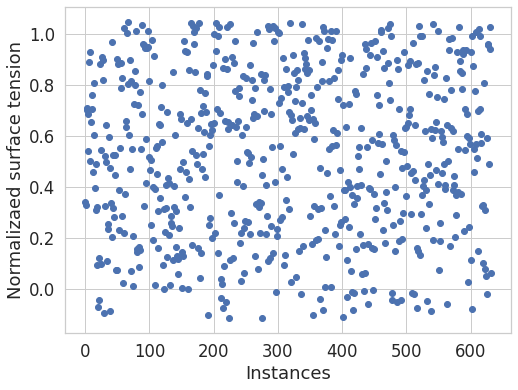

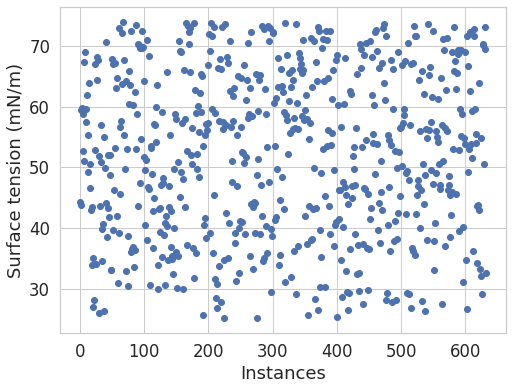

In [ ]:
#Descale target feature

#De-normalization check:
plt.figure(figsize=(8,6))
plt.scatter(range(len(new_test_labels)), new_test_labels)
plt.ylabel('Normalizaed surface tension')
plt.xlabel('Instances')

plt.figure(figsize=(8,6))
plt.scatter(range(len(ST_real_test)), ST_real_test)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instances')

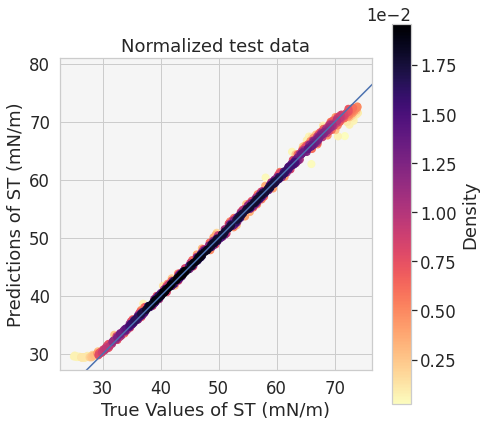

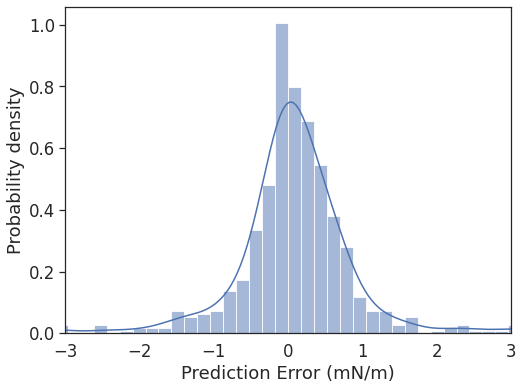

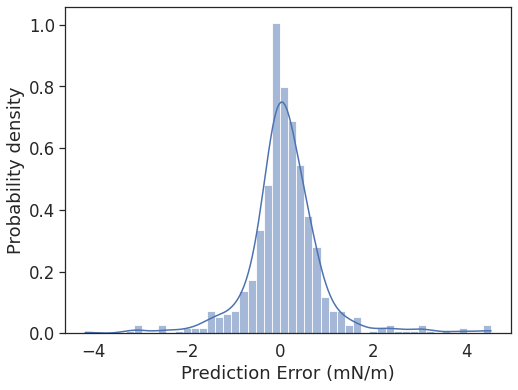

In [ ]:
error_test = ST_pred_test - ST_real_test
savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='png'

density_scatter(ST_real_test, ST_pred_test, title='Normalized test data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_test_data_'+figtype, dpi=300, format=figtype)

sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_lim_'+figtype, dpi=300, format=figtype)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
# plt.xticks(np.arange(-0.1, 0.15, step=0.05), [-0.1 , -0.05,  0.  ,  0.05,  0.1])
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_'+figtype, dpi=300, format=figtype)
plt.show()